## 1. Libraries 📖

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [3]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [4]:
df_train = pd.read_csv("../../data/train/geno/geno_maccs_train.csv")
df_test = pd.read_csv("../../data/train/geno/geno_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/geno/geno_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [5]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'genotoxicity']
y_train_all = df_train_all['genotoxicity']

X_train = df_train.loc[:, df_train.columns != 'genotoxicity']
y_train = df_train['genotoxicity']

X_test = df_test.loc[:, df_test.columns != 'genotoxicity']
y_test = df_test['genotoxicity']

X_valid = df_valid.loc[:, df_valid.columns != 'genotoxicity']
y_valid = df_valid['genotoxicity']

In [6]:
X_train.shape

(17440, 166)

In [7]:
X_test.shape

(4984, 166)

In [8]:
X_valid.shape

(2491, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [9]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [10]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [11]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=2491, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1.7854424617706088, Accuracy: -7.587219118952478
Test Avg. loss: 0.5726557970046997, Accuracy: -1.3922374827467672
################## EPOCH 2 ##################
Train Avg. loss: 1.335551047543867, Accuracy: -5.524341004896715
Test Avg. loss: 0.4046451449394226, Accuracy: -0.6903822537554163
################## EPOCH 3 ##################
Train Avg. loss: 1.1556512012394196, Accuracy: -4.603253251223972
Test Avg. loss: 0.5604894161224365, Accuracy: -1.3414128558873917
################## EPOCH 4 ##################
Train Avg. loss: 1.0083817784392506, Accuracy: -3.8798495260984356
Test Avg. loss: 0.6531376242637634, Accuracy: -1.7284458161355936
################## EPOCH 5 ##################
Train Avg. loss: 0.86941389075113, Accuracy: -3.2046839916747683
Test Avg. loss: 0.6047968864440918, Accuracy: -1.5265050318879547
################## EPOCH 6 ##################
Train Avg. loss: 0.768336737484013

Train Avg. loss: 0.19382322987011813, Accuracy: 0.1545315174923689
Test Avg. loss: 0.2059306502342224, Accuracy: 0.13973635023578246
################## EPOCH 47 ##################
Train Avg. loss: 0.19519426679119056, Accuracy: 0.14541129654933702
Test Avg. loss: 0.20262253284454346, Accuracy: 0.15355574685179108
################## EPOCH 48 ##################
Train Avg. loss: 0.19134561954014892, Accuracy: 0.16501127496943624
Test Avg. loss: 0.20613627135753632, Accuracy: 0.13887734763007886
################## EPOCH 49 ##################
Train Avg. loss: 0.18995737404724874, Accuracy: 0.16734753539524708
Test Avg. loss: 0.2036782205104828, Accuracy: 0.14914566823369735
################## EPOCH 50 ##################
Train Avg. loss: 0.19203153178779356, Accuracy: 0.15329753627518575
Test Avg. loss: 0.20692642033100128, Accuracy: 0.13557655199125607
################## EPOCH 51 ##################
Train Avg. loss: 0.189271128751816, Accuracy: 0.16590468395526264
Test Avg. loss: 0.203635066

Train Avg. loss: 0.17022704259928215, Accuracy: 0.23748390221576052
Test Avg. loss: 0.20538538694381714, Accuracy: 0.14201414616052888
################## EPOCH 93 ##################
Train Avg. loss: 0.16633886130304512, Accuracy: 0.2584019585510244
Test Avg. loss: 0.20427829027175903, Accuracy: 0.1466389726198788
################## EPOCH 94 ##################
Train Avg. loss: 0.16450642052730288, Accuracy: 0.263176056728242
Test Avg. loss: 0.20669272541999817, Accuracy: 0.13655277783655595
################## EPOCH 95 ##################
Train Avg. loss: 0.16536637960907516, Accuracy: 0.25404176796354666
Test Avg. loss: 0.20358353853225708, Accuracy: 0.14954117794570942
################## EPOCH 96 ##################
Train Avg. loss: 0.16593165880222932, Accuracy: 0.2607873502280901
Test Avg. loss: 0.20335035026073456, Accuracy: 0.15051537896085732
################## EPOCH 97 ##################
Train Avg. loss: 0.167329092686056, Accuracy: 0.25261516580370746
Test Avg. loss: 0.20513896644

Train Avg. loss: 0.15478692630972338, Accuracy: 0.30746406726707187
Test Avg. loss: 0.20041008293628693, Accuracy: 0.16279818865257678
################## EPOCH 139 ##################
Train Avg. loss: 0.15350719820195383, Accuracy: 0.304737316208641
Test Avg. loss: 0.19854669272899628, Accuracy: 0.17058237187676517
################## EPOCH 140 ##################
Train Avg. loss: 0.15289125880653706, Accuracy: 0.3100951378606684
Test Avg. loss: 0.20376288890838623, Accuracy: 0.14879198411972938
################## EPOCH 141 ##################
Train Avg. loss: 0.15313730885812996, Accuracy: 0.3122153259801017
Test Avg. loss: 0.20810972154140472, Accuracy: 0.13063335469698223
################## EPOCH 142 ##################
Train Avg. loss: 0.15241130662210492, Accuracy: 0.31298649233788634
Test Avg. loss: 0.20688654482364655, Accuracy: 0.1357431191936317
################## EPOCH 143 ##################
Train Avg. loss: 0.15145595248686064, Accuracy: 0.31421790577727504
Test Avg. loss: 0.2069

Train Avg. loss: 0.1443611725823048, Accuracy: 0.3487213124204032
Test Avg. loss: 0.21137817203998566, Accuracy: 0.11697955301884921
################## EPOCH 185 ##################
Train Avg. loss: 0.14577633370089968, Accuracy: 0.3417268922109502
Test Avg. loss: 0.20811250805854797, Accuracy: 0.1306217287193252
################## EPOCH 186 ##################
Train Avg. loss: 0.14346145463235882, Accuracy: 0.35520078690963586
Test Avg. loss: 0.2113991677761078, Accuracy: 0.1168917504102226
################## EPOCH 187 ##################
Train Avg. loss: 0.14408729386712432, Accuracy: 0.3491390650844673
Test Avg. loss: 0.2114175409078598, Accuracy: 0.11681510806979478
################## EPOCH 188 ##################
Train Avg. loss: 0.14369197532261183, Accuracy: 0.3511249385298049
Test Avg. loss: 0.20557796955108643, Accuracy: 0.14120960554133588
################## EPOCH 189 ##################
Train Avg. loss: 0.14346116835234363, Accuracy: 0.35511404464828106
Test Avg. loss: 0.21280391

Train Avg. loss: 0.1354756142089673, Accuracy: 0.38939877230299336
Test Avg. loss: 0.21155309677124023, Accuracy: 0.11624878475005329
################## EPOCH 231 ##################
Train Avg. loss: 0.13895669912389658, Accuracy: 0.37289599491273284
Test Avg. loss: 0.20641280710697174, Accuracy: 0.13772207431091277
################## EPOCH 232 ##################
Train Avg. loss: 0.13884795548035464, Accuracy: 0.374467452277032
Test Avg. loss: 0.20753608644008636, Accuracy: 0.13302967595255932
################## EPOCH 233 ##################
Train Avg. loss: 0.13817939957210776, Accuracy: 0.3775269717342833
Test Avg. loss: 0.2161228209733963, Accuracy: 0.09715912349150391
################## EPOCH 234 ##################
Train Avg. loss: 0.1368428841780085, Accuracy: 0.3844529841639282
Test Avg. loss: 0.22062461078166962, Accuracy: 0.07835313127539745
################## EPOCH 235 ##################
Train Avg. loss: 0.138391800293135, Accuracy: 0.37533925614020486
Test Avg. loss: 0.21057103

Train Avg. loss: 0.13234081791901808, Accuracy: 0.3995297622045474
Test Avg. loss: 0.21649253368377686, Accuracy: 0.09561462783402208
################## EPOCH 277 ##################
Train Avg. loss: 0.1320316173614712, Accuracy: 0.40337004250325437
Test Avg. loss: 0.21400520205497742, Accuracy: 0.10600528549512755
################## EPOCH 278 ##################
Train Avg. loss: 0.13107841494706793, Accuracy: 0.40270097265622296
Test Avg. loss: 0.21779301762580872, Accuracy: 0.09018194393935852
################## EPOCH 279 ##################
Train Avg. loss: 0.1324042491273049, Accuracy: 0.39945219230024864
Test Avg. loss: 0.2207457572221756, Accuracy: 0.07784710022771424
################## EPOCH 280 ##################
Train Avg. loss: 0.13503788405465422, Accuracy: 0.386443742988177
Test Avg. loss: 0.2147723287343979, Accuracy: 0.10280071130933444
################## EPOCH 281 ##################
Train Avg. loss: 0.1317886291293923, Accuracy: 0.4022099071549432
Test Avg. loss: 0.21186614

Train Avg. loss: 0.34131366838684013, Accuracy: -0.47395584165005766
Test Avg. loss: 0.22081470489501953, Accuracy: 0.07755899293906598
################## EPOCH 23 ##################
Train Avg. loss: 0.3309484791188013, Accuracy: -0.4227328760725063
Test Avg. loss: 0.2166498601436615, Accuracy: 0.09495738570181
################## EPOCH 24 ##################
Train Avg. loss: 0.3113870822684669, Accuracy: -0.3328968459327542
Test Avg. loss: 0.2164904922246933, Accuracy: 0.09562313457955662
################## EPOCH 25 ##################
Train Avg. loss: 0.2960583400049489, Accuracy: -0.2659456569384586
Test Avg. loss: 0.21609224379062653, Accuracy: 0.0972869221650069
################## EPOCH 26 ##################
Train Avg. loss: 0.28145988083584406, Accuracy: -0.1944128263319654
Test Avg. loss: 0.21550001204013824, Accuracy: 0.09976086459086309
################## EPOCH 27 ##################
Train Avg. loss: 0.2681434486375187, Accuracy: -0.1391862493941193
Test Avg. loss: 0.2131250798702

Train Avg. loss: 0.17434715264009468, Accuracy: 0.25757628825783324
Test Avg. loss: 0.20081168413162231, Accuracy: 0.1611205277861516
################## EPOCH 69 ##################
Train Avg. loss: 0.17208048624870104, Accuracy: 0.2700393719048687
Test Avg. loss: 0.2033814638853073, Accuracy: 0.1503853777364762
################## EPOCH 70 ##################
Train Avg. loss: 0.17102245020342396, Accuracy: 0.27356713495399054
Test Avg. loss: 0.20257186889648438, Accuracy: 0.15376742170545854
################## EPOCH 71 ##################
Train Avg. loss: 0.17091509506051794, Accuracy: 0.2727875942360369
Test Avg. loss: 0.20406556129455566, Accuracy: 0.14752768400317828
################## EPOCH 72 ##################
Train Avg. loss: 0.17121458926916996, Accuracy: 0.27203961885018624
Test Avg. loss: 0.2012273222208023, Accuracy: 0.15938417526811577
################## EPOCH 73 ##################
Train Avg. loss: 0.17302788886831794, Accuracy: 0.26509124787703725
Test Avg. loss: 0.2024252265

Train Avg. loss: 0.15143721045810224, Accuracy: 0.35000478997370565
Test Avg. loss: 0.20915861427783966, Accuracy: 0.1262516132717042
################## EPOCH 115 ##################
Train Avg. loss: 0.15237412830958, Accuracy: 0.34839567973165764
Test Avg. loss: 0.21138755977153778, Accuracy: 0.11694038362696879
################## EPOCH 116 ##################
Train Avg. loss: 0.14932009684188025, Accuracy: 0.36031958545203097
Test Avg. loss: 0.2118350714445114, Accuracy: 0.1150709302100682
################## EPOCH 117 ##################
Train Avg. loss: 0.15067920612764882, Accuracy: 0.3549545001862748
Test Avg. loss: 0.21253959834575653, Accuracy: 0.11212771560297863
################## EPOCH 118 ##################
Train Avg. loss: 0.1472603522595905, Accuracy: 0.3674648048781372
Test Avg. loss: 0.20584321022033691, Accuracy: 0.14010160595677534
################## EPOCH 119 ##################
Train Avg. loss: 0.1464483971287916, Accuracy: 0.3709899913976769
Test Avg. loss: 0.2056223154

Train Avg. loss: 0.14023810346702953, Accuracy: 0.39817789491696
Test Avg. loss: 0.2060881108045578, Accuracy: 0.13907843490441785
################## EPOCH 161 ##################
Train Avg. loss: 0.13395811143866826, Accuracy: 0.4216107407090327
Test Avg. loss: 0.20599031448364258, Accuracy: 0.13948702708572613
################## EPOCH 162 ##################
Train Avg. loss: 0.13485079651678, Accuracy: 0.4190885915397928
Test Avg. loss: 0.20201559364795685, Accuracy: 0.15609121421832894
################## EPOCH 163 ##################
Train Avg. loss: 0.13698590800657376, Accuracy: 0.4133287322684515
Test Avg. loss: 0.20459377765655518, Accuracy: 0.14532101576899759
################## EPOCH 164 ##################
Train Avg. loss: 0.13853874944505237, Accuracy: 0.3991818703082828
Test Avg. loss: 0.20291952788829803, Accuracy: 0.1523150685805853
################## EPOCH 165 ##################
Train Avg. loss: 0.13506549629536305, Accuracy: 0.4182324198384966
Test Avg. loss: 0.204124063253

Train Avg. loss: 0.1280077128183274, Accuracy: 0.4487191629038154
Test Avg. loss: 0.2066391557455063, Accuracy: 0.13677649402271141
################## EPOCH 207 ##################
Train Avg. loss: 0.12592566022888207, Accuracy: 0.4579143699097444
Test Avg. loss: 0.20793281495571136, Accuracy: 0.13137240852528698
################## EPOCH 208 ##################
Train Avg. loss: 0.12882266672594206, Accuracy: 0.4449806768153494
Test Avg. loss: 0.20480778813362122, Accuracy: 0.14442696016949652
################## EPOCH 209 ##################
Train Avg. loss: 0.12859323919638171, Accuracy: 0.44721329411671173
Test Avg. loss: 0.20443440973758698, Accuracy: 0.14598676798110322
################## EPOCH 210 ##################
Train Avg. loss: 0.12664933658235675, Accuracy: 0.4518823087075653
Test Avg. loss: 0.20121073722839355, Accuracy: 0.15945345015500623
################## EPOCH 211 ##################
Train Avg. loss: 0.1245793800787393, Accuracy: 0.46207872565230906
Test Avg. loss: 0.204037

Train Avg. loss: 0.12123324052045197, Accuracy: 0.4751809110701437
Test Avg. loss: 0.20489908754825592, Accuracy: 0.14404562274320787
################## EPOCH 253 ##################
Train Avg. loss: 0.12217674186050674, Accuracy: 0.475495568573907
Test Avg. loss: 0.21688134968280792, Accuracy: 0.09399042007974079
################## EPOCH 254 ##################
Train Avg. loss: 0.12070756584351316, Accuracy: 0.48056039241261345
Test Avg. loss: 0.20761434733867645, Accuracy: 0.13270268422979725
################## EPOCH 255 ##################
Train Avg. loss: 0.12103602284695203, Accuracy: 0.4752177180998036
Test Avg. loss: 0.20950794219970703, Accuracy: 0.1247924138251123
################## EPOCH 256 ##################
Train Avg. loss: 0.12184666173580365, Accuracy: 0.47390603214733146
Test Avg. loss: 0.20790395140647888, Accuracy: 0.13149299348003096
################## EPOCH 257 ##################
Train Avg. loss: 0.12336574176892692, Accuracy: 0.46782024576415787
Test Avg. loss: 0.2098

Train Avg. loss: 0.11800488154148008, Accuracy: 0.4916188529616745
Test Avg. loss: 0.21200981736183167, Accuracy: 0.1143409522759945
################## EPOCH 299 ##################
Train Avg. loss: 0.11759770317719533, Accuracy: 0.49324475484755537
Test Avg. loss: 0.2061886191368103, Accuracy: 0.13865858635275763
################## EPOCH 300 ##################
Train Avg. loss: 0.11782081822281355, Accuracy: 0.49052434260507105
Test Avg. loss: 0.22179275751113892, Accuracy: 0.07347324623133733
Model: lr 0.001, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 2.4567226241104794, Accuracy: -9.252527223505803
Test Avg. loss: 0.9350867867469788, Accuracy: -2.9062725210709766
################## EPOCH 2 ##################
Train Avg. loss: 1.4167193004684726, Accuracy: -5.128006028006593
Test Avg. loss: 0.9096587300300598, Accuracy: -2.8000481301907594
################## EPOCH 3 ##################
Train Avg. loss: 1.4006840503998916, Accuracy: -5.045062055575336
Te

Train Avg. loss: 0.32449086086593404, Accuracy: -0.36658826131282635
Test Avg. loss: 0.22747212648391724, Accuracy: 0.04974805947654115
################## EPOCH 45 ##################
Train Avg. loss: 0.3129207167747247, Accuracy: -0.32093425563553085
Test Avg. loss: 0.216024249792099, Accuracy: 0.097570934430255
################## EPOCH 46 ##################
Train Avg. loss: 0.3014862096875253, Accuracy: -0.27087675378643405
Test Avg. loss: 0.217178612947464, Accuracy: 0.09274857140676407
################## EPOCH 47 ##################
Train Avg. loss: 0.2950136085061261, Accuracy: -0.24081951701639875
Test Avg. loss: 0.21222680807113647, Accuracy: 0.11343447909422322
################## EPOCH 48 ##################
Train Avg. loss: 0.2859114720656054, Accuracy: -0.2044454428780063
Test Avg. loss: 0.20938919484615326, Accuracy: 0.12528845759325824
################## EPOCH 49 ##################
Train Avg. loss: 0.27714820793510353, Accuracy: -0.16345889434586913
Test Avg. loss: 0.209513619

Train Avg. loss: 0.16302578151226044, Accuracy: 0.31482884496819796
Test Avg. loss: 0.19546598196029663, Accuracy: 0.1834518185287244
################## EPOCH 91 ##################
Train Avg. loss: 0.1558222809847254, Accuracy: 0.3435644992406663
Test Avg. loss: 0.1932034194469452, Accuracy: 0.19290361108648513
################## EPOCH 92 ##################
Train Avg. loss: 0.1540254082557929, Accuracy: 0.35042153411750376
Test Avg. loss: 0.19911372661590576, Accuracy: 0.16821359270435854
################## EPOCH 93 ##################
Train Avg. loss: 0.15806309737428262, Accuracy: 0.336537201077814
Test Avg. loss: 0.19611790776252747, Accuracy: 0.18072849424710746
################## EPOCH 94 ##################
Train Avg. loss: 0.15828559270305356, Accuracy: 0.3357074079365915
Test Avg. loss: 0.19644461572170258, Accuracy: 0.17936370431579696
################## EPOCH 95 ##################
Train Avg. loss: 0.15686043134353456, Accuracy: 0.3409454153998865
Test Avg. loss: 0.2041311711072

Train Avg. loss: 0.13794594152021583, Accuracy: 0.41781721888431195
Test Avg. loss: 0.2034432590007782, Accuracy: 0.15012725401658966
################## EPOCH 137 ##################
Train Avg. loss: 0.1367062113798448, Accuracy: 0.424124543863953
Test Avg. loss: 0.20719750225543976, Accuracy: 0.13444411519816646
################## EPOCH 138 ##################
Train Avg. loss: 0.1347237053143717, Accuracy: 0.43035970073378543
Test Avg. loss: 0.20645177364349365, Accuracy: 0.13755939805540118
################## EPOCH 139 ##################
Train Avg. loss: 0.13692742994014365, Accuracy: 0.41993492988198283
Test Avg. loss: 0.20811600983142853, Accuracy: 0.130607107515458
################## EPOCH 140 ##################
Train Avg. loss: 0.13549617090581978, Accuracy: 0.43037915968103124
Test Avg. loss: 0.2234216183423996, Accuracy: 0.06666868498094303
################## EPOCH 141 ##################
Train Avg. loss: 0.13414215106163582, Accuracy: 0.4328396699879605
Test Avg. loss: 0.22663573

Train Avg. loss: 0.12448703644484499, Accuracy: 0.47402556923920997
Test Avg. loss: 0.21063989400863647, Accuracy: 0.1200637335751027
################## EPOCH 183 ##################
Train Avg. loss: 0.12571217250214875, Accuracy: 0.4706882198392313
Test Avg. loss: 0.21165168285369873, Accuracy: 0.11583694971231184
################## EPOCH 184 ##################
Train Avg. loss: 0.12452062126928873, Accuracy: 0.47012127330660003
Test Avg. loss: 0.2052188217639923, Accuracy: 0.14270995080888715
################## EPOCH 185 ##################
Train Avg. loss: 0.12568670919124228, Accuracy: 0.4679912356404187
Test Avg. loss: 0.21571139991283417, Accuracy: 0.09887781831089137
################## EPOCH 186 ##################
Train Avg. loss: 0.12816566326757417, Accuracy: 0.45708596190955836
Test Avg. loss: 0.2046358287334442, Accuracy: 0.1451453250591811
################## EPOCH 187 ##################
Train Avg. loss: 0.12511585777910955, Accuracy: 0.4714633465445104
Test Avg. loss: 0.210340

Train Avg. loss: 0.11815883725011436, Accuracy: 0.49947762795504863
Test Avg. loss: 0.2079324722290039, Accuracy: 0.1313738227141824
################## EPOCH 229 ##################
Train Avg. loss: 0.11709107317193582, Accuracy: 0.5028955484395018
Test Avg. loss: 0.210435152053833, Accuracy: 0.12091900348259477
################## EPOCH 230 ##################
Train Avg. loss: 0.11586323029694766, Accuracy: 0.5102295415691986
Test Avg. loss: 0.20615151524543762, Accuracy: 0.13881372558189264
################## EPOCH 231 ##################
Train Avg. loss: 0.11625643031005442, Accuracy: 0.5048297297633755
Test Avg. loss: 0.21519623696804047, Accuracy: 0.10102986111386669
################## EPOCH 232 ##################
Train Avg. loss: 0.1164354440504617, Accuracy: 0.5069326157031517
Test Avg. loss: 0.21464145183563232, Accuracy: 0.10334730612145082
################## EPOCH 233 ##################
Train Avg. loss: 0.1165611724892672, Accuracy: 0.5078547290271312
Test Avg. loss: 0.2078945189

Train Avg. loss: 0.11108341660812823, Accuracy: 0.5285463146647581
Test Avg. loss: 0.21185387670993805, Accuracy: 0.114992356831362
################## EPOCH 275 ##################
Train Avg. loss: 0.11134089456096183, Accuracy: 0.5289584302054184
Test Avg. loss: 0.21668031811714172, Accuracy: 0.0948301520221243
################## EPOCH 276 ##################
Train Avg. loss: 0.11034708826320015, Accuracy: 0.5324903754950241
Test Avg. loss: 0.22035852074623108, Accuracy: 0.07946474356400102
################## EPOCH 277 ##################
Train Avg. loss: 0.10873546386069625, Accuracy: 0.5355486620037739
Test Avg. loss: 0.2156899869441986, Accuracy: 0.09896725898884329
################## EPOCH 278 ##################
Train Avg. loss: 0.11261874660305733, Accuracy: 0.5218774661140506
Test Avg. loss: 0.214301198720932, Accuracy: 0.10476879431905961
################## EPOCH 279 ##################
Train Avg. loss: 0.11044676101555789, Accuracy: 0.5309998657997658
Test Avg. loss: 0.21845342218

Train Avg. loss: 1.1537925350493279, Accuracy: -3.861187111456082
Test Avg. loss: 0.6215993762016296, Accuracy: -1.5966962789655543
################## EPOCH 21 ##################
Train Avg. loss: 1.1312625770983489, Accuracy: -3.762088467432365
Test Avg. loss: 0.6621658802032471, Accuracy: -1.7661606101005591
################## EPOCH 22 ##################
Train Avg. loss: 1.1135838403218035, Accuracy: -3.6946459344736224
Test Avg. loss: 0.6124210953712463, Accuracy: -1.5583547304418803
################## EPOCH 23 ##################
Train Avg. loss: 1.083426188731539, Accuracy: -3.585174233014047
Test Avg. loss: 0.7282454967498779, Accuracy: -2.042204492390028
################## EPOCH 24 ##################
Train Avg. loss: 1.0592537738274836, Accuracy: -3.4715675613414763
Test Avg. loss: 1.1450130939483643, Accuracy: -3.7832275936184283
################## EPOCH 25 ##################
Train Avg. loss: 1.0344456848890886, Accuracy: -3.3625435778329242
Test Avg. loss: 0.8491732478141785, Ac

Train Avg. loss: 0.43235123243884765, Accuracy: -0.8114631441962609
Test Avg. loss: 0.28476569056510925, Accuracy: -0.18959254172025086
################## EPOCH 67 ##################
Train Avg. loss: 0.42603114074555, Accuracy: -0.7861906060380812
Test Avg. loss: 0.2745903730392456, Accuracy: -0.14708584644978506
################## EPOCH 68 ##################
Train Avg. loss: 0.42726965615714807, Accuracy: -0.7867018955586254
Test Avg. loss: 0.2641270160675049, Accuracy: -0.10337584429407709
################## EPOCH 69 ##################
Train Avg. loss: 0.41633776672508405, Accuracy: -0.7386202734615546
Test Avg. loss: 0.27472126483917236, Accuracy: -0.1476325579706914
################## EPOCH 70 ##################
Train Avg. loss: 0.39793714405833813, Accuracy: -0.665263068352409
Test Avg. loss: 0.25802674889564514, Accuracy: -0.07789229849172918
################## EPOCH 71 ##################
Train Avg. loss: 0.3886711999126103, Accuracy: -0.6265553864395379
Test Avg. loss: 0.2957379

Train Avg. loss: 0.18206957868043927, Accuracy: 0.24349915624896795
Test Avg. loss: 0.20378801226615906, Accuracy: 0.14868699536059804
################## EPOCH 113 ##################
Train Avg. loss: 0.17763298922690793, Accuracy: 0.2616102483009873
Test Avg. loss: 0.19949916005134583, Accuracy: 0.16660344691258222
################## EPOCH 114 ##################
Train Avg. loss: 0.17923260782507883, Accuracy: 0.25397568208886273
Test Avg. loss: 0.19857420027256012, Accuracy: 0.17046743967061562
################## EPOCH 115 ##################
Train Avg. loss: 0.1755972490578458, Accuracy: 0.27110638277573706
Test Avg. loss: 0.20049145817756653, Accuracy: 0.162458281447448
################## EPOCH 116 ##################
Train Avg. loss: 0.17635104729645495, Accuracy: 0.26626254260009113
Test Avg. loss: 0.20230260491371155, Accuracy: 0.1548922425354976
################## EPOCH 117 ##################
Train Avg. loss: 0.1722582934991173, Accuracy: 0.28291902767562527
Test Avg. loss: 0.19886

Train Avg. loss: 0.13924513595259708, Accuracy: 0.41959119136529816
Test Avg. loss: 0.20548424124717712, Accuracy: 0.14160111547177023
################## EPOCH 159 ##################
Train Avg. loss: 0.135834694556568, Accuracy: 0.43465550964712585
Test Avg. loss: 0.20037083327770233, Accuracy: 0.1629621325644709
################## EPOCH 160 ##################
Train Avg. loss: 0.13871360867135768, Accuracy: 0.4218447000027648
Test Avg. loss: 0.20600935816764832, Accuracy: 0.13940750290638693
################## EPOCH 161 ##################
Train Avg. loss: 0.13977520988471265, Accuracy: 0.41783295403638565
Test Avg. loss: 0.1988505721092224, Accuracy: 0.16931297963285363
################## EPOCH 162 ##################
Train Avg. loss: 0.13721418332146562, Accuracy: 0.42843102843610414
Test Avg. loss: 0.20041951537132263, Accuracy: 0.16275874680957048
################## EPOCH 163 ##################
Train Avg. loss: 0.1393950565893581, Accuracy: 0.4188348758357663
Test Avg. loss: 0.203656

Train Avg. loss: 0.12618504594201627, Accuracy: 0.4733407116947082
Test Avg. loss: 0.204870343208313, Accuracy: 0.14416561739500544
################## EPOCH 205 ##################
Train Avg. loss: 0.1239782147973344, Accuracy: 0.4838931874545415
Test Avg. loss: 0.20933198928833008, Accuracy: 0.12552746890843314
################## EPOCH 206 ##################
Train Avg. loss: 0.12490361777768619, Accuracy: 0.47955621985056746
Test Avg. loss: 0.21135202050209045, Accuracy: 0.11708885613862074
################## EPOCH 207 ##################
Train Avg. loss: 0.12629123204860135, Accuracy: 0.47387259070893967
Test Avg. loss: 0.20612260699272156, Accuracy: 0.13893437702725453
################## EPOCH 208 ##################
Train Avg. loss: 0.12485639804947203, Accuracy: 0.4789989386555977
Test Avg. loss: 0.20615342259407043, Accuracy: 0.13880566515900228
################## EPOCH 209 ##################
Train Avg. loss: 0.12388226422278778, Accuracy: 0.48383653518011965
Test Avg. loss: 0.20686

Train Avg. loss: 0.11886485989974893, Accuracy: 0.5030060440799451
Test Avg. loss: 0.20244191586971283, Accuracy: 0.15431032804623035
################## EPOCH 251 ##################
Train Avg. loss: 0.11735284857559895, Accuracy: 0.5103875511190973
Test Avg. loss: 0.21046997606754303, Accuracy: 0.12077356653174243
################## EPOCH 252 ##################
Train Avg. loss: 0.11887264327294585, Accuracy: 0.5030570202969582
Test Avg. loss: 0.20411905646324158, Accuracy: 0.1473041092373395
################## EPOCH 253 ##################
Train Avg. loss: 0.11670221423433311, Accuracy: 0.5129857722248928
Test Avg. loss: 0.20393168926239014, Accuracy: 0.14808684521571835
################## EPOCH 254 ##################
Train Avg. loss: 0.1149244179436262, Accuracy: 0.5197249966086281
Test Avg. loss: 0.2105344831943512, Accuracy: 0.12050406213454545
################## EPOCH 255 ##################
Train Avg. loss: 0.11447998724769855, Accuracy: 0.5203594898216631
Test Avg. loss: 0.21007525

Train Avg. loss: 0.1116015277263047, Accuracy: 0.5332307606535296
Test Avg. loss: 0.21056173741817474, Accuracy: 0.12039018352801112
################## EPOCH 297 ##################
Train Avg. loss: 0.1104191389420758, Accuracy: 0.5386090230468192
Test Avg. loss: 0.20876644551753998, Accuracy: 0.1278899436137454
################## EPOCH 298 ##################
Train Avg. loss: 0.11110736364903658, Accuracy: 0.5364289985271944
Test Avg. loss: 0.2026682049036026, Accuracy: 0.15336499699744732
################## EPOCH 299 ##################
Train Avg. loss: 0.10806381799604582, Accuracy: 0.5467738546912921
Test Avg. loss: 0.20747625827789307, Accuracy: 0.13327970492224095
################## EPOCH 300 ##################
Train Avg. loss: 0.10774327355666437, Accuracy: 0.5484539916976758
Test Avg. loss: 0.2042323499917984, Accuracy: 0.14683083733586344
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1.8614588722176508, Accuracy: -7.9321950475334955

Train Avg. loss: 0.2374116545833579, Accuracy: -0.012657757656362149
Test Avg. loss: 0.22978386282920837, Accuracy: 0.040090877111081946
################## EPOCH 42 ##################
Train Avg. loss: 0.2361676696243636, Accuracy: -0.010474309553282837
Test Avg. loss: 0.2303217351436615, Accuracy: 0.03784395881298552
################## EPOCH 43 ##################
Train Avg. loss: 0.2352111468758058, Accuracy: -0.0049566875260452494
Test Avg. loss: 0.229906365275383, Accuracy: 0.03957906891625895
################## EPOCH 44 ##################
Train Avg. loss: 0.23610117048571963, Accuracy: -0.008481828425845219
Test Avg. loss: 0.22849217057228088, Accuracy: 0.0454867878110784
################## EPOCH 45 ##################
Train Avg. loss: 0.2350729176347409, Accuracy: -0.005844526281621174
Test Avg. loss: 0.22995559871196747, Accuracy: 0.039373440354651845
################## EPOCH 46 ##################
Train Avg. loss: 0.23534240041850904, Accuracy: -0.007012365684943541
Test Avg. loss:

Train Avg. loss: 0.23772258660115234, Accuracy: -0.01727764920072184
Test Avg. loss: 0.22957254946231842, Accuracy: 0.040973586523635364
################## EPOCH 87 ##################
Train Avg. loss: 0.23945253178340578, Accuracy: -0.02373379114061149
Test Avg. loss: 0.22985662519931793, Accuracy: 0.03978683532583838
################## EPOCH 88 ##################
Train Avg. loss: 0.23680347957468909, Accuracy: -0.012677451682120916
Test Avg. loss: 0.2296493947505951, Accuracy: 0.04065261835644807
################## EPOCH 89 ##################
Train Avg. loss: 0.23642942822034205, Accuracy: -0.010224173405738543
Test Avg. loss: 0.23058602213859558, Accuracy: 0.036740022061366395
################## EPOCH 90 ##################
Train Avg. loss: 0.23836696996874765, Accuracy: -0.017613301529132496
Test Avg. loss: 0.23093323409557343, Accuracy: 0.03528939396370401
################## EPOCH 91 ##################
Train Avg. loss: 0.2364790702768422, Accuracy: -0.009679198080921944
Test Avg. lo

Train Avg. loss: 0.2434595765323814, Accuracy: -0.039619980260674585
Test Avg. loss: 0.23971225321292877, Accuracy: -0.0013844657625381451
################## EPOCH 132 ##################
Train Avg. loss: 0.24341428925138, Accuracy: -0.03930221236374305
Test Avg. loss: 0.23971524834632874, Accuracy: -0.0013968906549819415
################## EPOCH 133 ##################
Train Avg. loss: 0.24342501200393798, Accuracy: -0.03933422079485246
Test Avg. loss: 0.23971232771873474, Accuracy: -0.0013846799492522877
################## EPOCH 134 ##################
Train Avg. loss: 0.24342741215721184, Accuracy: -0.039341557607379896
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 135 ##################
Train Avg. loss: 0.2434248728626365, Accuracy: -0.039333692327435714
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 136 ##################
Train Avg. loss: 0.24342487455781447, Accuracy: -0.0393337017391328

Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 176 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 177 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 178 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 179 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 180 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705

Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 220 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 221 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 222 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 223 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 224 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705

Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 264 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 265 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 266 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 267 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 268 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705

Train Avg. loss: 0.3046076122002724, Accuracy: -0.29390979281616153
Test Avg. loss: 0.23189431428909302, Accuracy: 0.03127453607629915
################## EPOCH 8 ##################
Train Avg. loss: 0.2654183022814356, Accuracy: -0.11922954304603546
Test Avg. loss: 0.22411251068115234, Accuracy: 0.06378259587669566
################## EPOCH 9 ##################
Train Avg. loss: 0.24476013062419472, Accuracy: -0.02715755711833455
Test Avg. loss: 0.2231740802526474, Accuracy: 0.0677028401220986
################## EPOCH 10 ##################
Train Avg. loss: 0.23594557450258688, Accuracy: 0.011798627275965213
Test Avg. loss: 0.22205430269241333, Accuracy: 0.07238069820603987
################## EPOCH 11 ##################
Train Avg. loss: 0.23106677109723564, Accuracy: 0.03333930161250435
Test Avg. loss: 0.22000648081302643, Accuracy: 0.08093539988693355
################## EPOCH 12 ##################
Train Avg. loss: 0.22896441454306626, Accuracy: 0.04210932483699552
Test Avg. loss: 0.220421

Train Avg. loss: 0.22526056876221856, Accuracy: 0.05677848856132937
Test Avg. loss: 0.21880821883678436, Accuracy: 0.08594096994844846
################## EPOCH 54 ##################
Train Avg. loss: 0.2289779027958056, Accuracy: 0.03917248394570155
Test Avg. loss: 0.2227962464094162, Accuracy: 0.06928123490978844
################## EPOCH 55 ##################
Train Avg. loss: 0.22687644899000614, Accuracy: 0.046508548979485774
Test Avg. loss: 0.2159639149904251, Accuracy: 0.09782288157196861
################## EPOCH 56 ##################
Train Avg. loss: 0.22735523276931638, Accuracy: 0.045354805590802356
Test Avg. loss: 0.21541257202625275, Accuracy: 0.10012609858958421
################## EPOCH 57 ##################
Train Avg. loss: 0.22411721928434059, Accuracy: 0.060247653673415544
Test Avg. loss: 0.21986132860183716, Accuracy: 0.08154171768248042
################## EPOCH 58 ##################
Train Avg. loss: 0.22357437279307363, Accuracy: 0.05886544272141308
Test Avg. loss: 0.2147

Train Avg. loss: 0.21573341905306548, Accuracy: 0.09386708357148422
Test Avg. loss: 0.21534021198749542, Accuracy: 0.10042836391348553
################## EPOCH 100 ##################
Train Avg. loss: 0.22180109181792745, Accuracy: 0.06943258140883077
Test Avg. loss: 0.21480032801628113, Accuracy: 0.10268377045440003
################## EPOCH 101 ##################
Train Avg. loss: 0.21944557556084224, Accuracy: 0.07657867450572142
Test Avg. loss: 0.22278547286987305, Accuracy: 0.06932616680307047
################## EPOCH 102 ##################
Train Avg. loss: 0.2186857745215133, Accuracy: 0.0820118442806198
Test Avg. loss: 0.21893464028835297, Accuracy: 0.08541289153833798
################## EPOCH 103 ##################
Train Avg. loss: 0.22178760894161442, Accuracy: 0.0694238720931061
Test Avg. loss: 0.22370308637619019, Accuracy: 0.06549307032532559
################## EPOCH 104 ##################
Train Avg. loss: 0.2248485924287157, Accuracy: 0.05520248219127191
Test Avg. loss: 0.217

Train Avg. loss: 0.21007192134857178, Accuracy: 0.11166211988726522
Test Avg. loss: 0.21776515245437622, Accuracy: 0.09029833122467712
################## EPOCH 145 ##################
Train Avg. loss: 0.2123116216325498, Accuracy: 0.10569896099977422
Test Avg. loss: 0.2145306020975113, Accuracy: 0.10381043306584226
################## EPOCH 146 ##################
Train Avg. loss: 0.21453639204467173, Accuracy: 0.09862932212462289
Test Avg. loss: 0.21833713352680206, Accuracy: 0.08790892643610226
################## EPOCH 147 ##################
Train Avg. loss: 0.21323143316930904, Accuracy: 0.10276724312824896
Test Avg. loss: 0.2174685001373291, Accuracy: 0.09153757245880623
################## EPOCH 148 ##################
Train Avg. loss: 0.21450165776542693, Accuracy: 0.09624033029761345
Test Avg. loss: 0.21936146914958954, Accuracy: 0.08362981255737034
################## EPOCH 149 ##################
Train Avg. loss: 0.21577779790420673, Accuracy: 0.09223250317003479
Test Avg. loss: 0.21

Train Avg. loss: 0.2098969599921188, Accuracy: 0.11757338179584734
Test Avg. loss: 0.21150673925876617, Accuracy: 0.11644249186727262
################## EPOCH 191 ##################
Train Avg. loss: 0.2085950071667577, Accuracy: 0.12234947652223348
Test Avg. loss: 0.21437886357307434, Accuracy: 0.10444435641126404
################## EPOCH 192 ##################
Train Avg. loss: 0.21020422384634121, Accuracy: 0.1159718057816801
Test Avg. loss: 0.21249805390834808, Accuracy: 0.1123014253495338
################## EPOCH 193 ##################
Train Avg. loss: 0.2075639497829881, Accuracy: 0.12305382190427962
Test Avg. loss: 0.21580883860588074, Accuracy: 0.09847075254824289
################## EPOCH 194 ##################
Train Avg. loss: 0.20624924844110404, Accuracy: 0.12967547679540586
Test Avg. loss: 0.2164801061153412, Accuracy: 0.09566659021293
################## EPOCH 195 ##################
Train Avg. loss: 0.20980600199419938, Accuracy: 0.11627301412311979
Test Avg. loss: 0.21335516

Train Avg. loss: 0.20415152882263338, Accuracy: 0.13840185040112263
Test Avg. loss: 0.210147887468338, Accuracy: 0.12211899689122008
################## EPOCH 237 ##################
Train Avg. loss: 0.20311468386606418, Accuracy: 0.1450338247067789
Test Avg. loss: 0.20891551673412323, Accuracy: 0.12726715199997118
################## EPOCH 238 ##################
Train Avg. loss: 0.20266474717920954, Accuracy: 0.1449057915047833
Test Avg. loss: 0.21224454045295715, Accuracy: 0.11336030352418591
################## EPOCH 239 ##################
Train Avg. loss: 0.2024067386220663, Accuracy: 0.14512221984801218
Test Avg. loss: 0.21178917586803436, Accuracy: 0.11526265743412845
################## EPOCH 240 ##################
Train Avg. loss: 0.20446057118229813, Accuracy: 0.14040828997630975
Test Avg. loss: 0.21136628091335297, Accuracy: 0.1170293062702128
################## EPOCH 241 ##################
Train Avg. loss: 0.20509451906104664, Accuracy: 0.1367706877711878
Test Avg. loss: 0.211069

Train Avg. loss: 0.19858123452126325, Accuracy: 0.1622262253513171
Test Avg. loss: 0.20704947412014008, Accuracy: 0.13506247801054527
################## EPOCH 283 ##################
Train Avg. loss: 0.20332910115028913, Accuracy: 0.14216724446011664
Test Avg. loss: 0.21019861102104187, Accuracy: 0.1219071221852932
################## EPOCH 284 ##################
Train Avg. loss: 0.19932277514275176, Accuracy: 0.16302086916061018
Test Avg. loss: 0.2047097384929657, Accuracy: 0.1448366230559237
################## EPOCH 285 ##################
Train Avg. loss: 0.20061614975715295, Accuracy: 0.14943958634982446
Test Avg. loss: 0.20779626071453094, Accuracy: 0.1319428073789738
################## EPOCH 286 ##################
Train Avg. loss: 0.19720062684445155, Accuracy: 0.16886682133888803
Test Avg. loss: 0.2076217532157898, Accuracy: 0.13267177654148898
################## EPOCH 287 ##################
Train Avg. loss: 0.1978725214580913, Accuracy: 0.16816387322936613
Test Avg. loss: 0.208305

Train Avg. loss: 0.2187792771924151, Accuracy: 0.09056052782379238
Test Avg. loss: 0.21551643311977386, Accuracy: 0.09969218960814008
################## EPOCH 29 ##################
Train Avg. loss: 0.2186237911890893, Accuracy: 0.09103415314739462
Test Avg. loss: 0.21693839132785797, Accuracy: 0.09375209226379
################## EPOCH 30 ##################
Train Avg. loss: 0.21787560127512381, Accuracy: 0.0929096071881864
Test Avg. loss: 0.20925815403461456, Accuracy: 0.12583572211527227
################## EPOCH 31 ##################
Train Avg. loss: 0.21645818128638025, Accuracy: 0.10036549328302954
Test Avg. loss: 0.2104671597480774, Accuracy: 0.12078525950642804
################## EPOCH 32 ##################
Train Avg. loss: 0.21744945813922117, Accuracy: 0.0953130224232582
Test Avg. loss: 0.2153899073600769, Accuracy: 0.10022082299176038
################## EPOCH 33 ##################
Train Avg. loss: 0.21471799203079112, Accuracy: 0.10739781685772984
Test Avg. loss: 0.2095244526863

Train Avg. loss: 0.1956622394984656, Accuracy: 0.18391081871999027
Test Avg. loss: 0.20465628802776337, Accuracy: 0.1450598387834633
################## EPOCH 75 ##################
Train Avg. loss: 0.19591602335011002, Accuracy: 0.18154857789223441
Test Avg. loss: 0.2067410945892334, Accuracy: 0.13635078418909818
################## EPOCH 76 ##################
Train Avg. loss: 0.19395596816809507, Accuracy: 0.1888972753836497
Test Avg. loss: 0.2049972414970398, Accuracy: 0.14363556758633433
################## EPOCH 77 ##################
Train Avg. loss: 0.1934935999286436, Accuracy: 0.18959318633311556
Test Avg. loss: 0.2061445564031601, Accuracy: 0.13884270627633366
################## EPOCH 78 ##################
Train Avg. loss: 0.19388151625647163, Accuracy: 0.1908149891973857
Test Avg. loss: 0.20591852068901062, Accuracy: 0.1397869474941389
################## EPOCH 79 ##################
Train Avg. loss: 0.19060831968366665, Accuracy: 0.20267830285008434
Test Avg. loss: 0.2069905251264

Train Avg. loss: 0.18007517437430193, Accuracy: 0.244949606096184
Test Avg. loss: 0.20381779968738556, Accuracy: 0.14856264592908508
################## EPOCH 121 ##################
Train Avg. loss: 0.1793692516040628, Accuracy: 0.24799854344396594
Test Avg. loss: 0.20552493631839752, Accuracy: 0.1414311150644274
################## EPOCH 122 ##################
Train Avg. loss: 0.17833636527078867, Accuracy: 0.2515434212916002
Test Avg. loss: 0.20224779844284058, Accuracy: 0.15512121799582568
################## EPOCH 123 ##################
Train Avg. loss: 0.18109941618503445, Accuracy: 0.24494752139849174
Test Avg. loss: 0.19980260729789734, Accuracy: 0.1653358561994902
################## EPOCH 124 ##################
Train Avg. loss: 0.1800272551766277, Accuracy: 0.2467584753132892
Test Avg. loss: 0.20464925467967987, Accuracy: 0.14508927320048093
################## EPOCH 125 ##################
Train Avg. loss: 0.18276833628650999, Accuracy: 0.23512932855466298
Test Avg. loss: 0.2126436

Train Avg. loss: 0.16867680320121947, Accuracy: 0.2901451130131404
Test Avg. loss: 0.19929152727127075, Accuracy: 0.16747084722069716
################## EPOCH 167 ##################
Train Avg. loss: 0.17267289496686336, Accuracy: 0.273998849132237
Test Avg. loss: 0.19893060624599457, Accuracy: 0.16897861705877415
################## EPOCH 168 ##################
Train Avg. loss: 0.17169689131479193, Accuracy: 0.27842782370308927
Test Avg. loss: 0.20174628496170044, Accuracy: 0.15721628685026323
################## EPOCH 169 ##################
Train Avg. loss: 0.16778869728428603, Accuracy: 0.2954464143346236
Test Avg. loss: 0.19913098216056824, Accuracy: 0.16814160137820078
################## EPOCH 170 ##################
Train Avg. loss: 0.16942647790169194, Accuracy: 0.28821833743541925
Test Avg. loss: 0.20083288848400116, Accuracy: 0.16103191405584671
################## EPOCH 171 ##################
Train Avg. loss: 0.16697790952277008, Accuracy: 0.29709755318432624
Test Avg. loss: 0.202

Train Avg. loss: 0.16312009819450168, Accuracy: 0.31523624751929247
Test Avg. loss: 0.19864143431186676, Accuracy: 0.17018656002254928
################## EPOCH 213 ##################
Train Avg. loss: 0.16471170601401017, Accuracy: 0.3060751043181135
Test Avg. loss: 0.20014835894107819, Accuracy: 0.16389150733322988
################## EPOCH 214 ##################
Train Avg. loss: 0.16452016975105244, Accuracy: 0.3084843284476963
Test Avg. loss: 0.1993454545736313, Accuracy: 0.1672456101831321
################## EPOCH 215 ##################
Train Avg. loss: 0.1646192772653851, Accuracy: 0.30813145508132045
Test Avg. loss: 0.20282095670700073, Accuracy: 0.15272692101766805
################## EPOCH 216 ##################
Train Avg. loss: 0.16680915569410706, Accuracy: 0.2991325395268874
Test Avg. loss: 0.2009984701871872, Accuracy: 0.16034017702697234
################## EPOCH 217 ##################
Train Avg. loss: 0.16729476824946646, Accuracy: 0.2969796502851374
Test Avg. loss: 0.2020643

Train Avg. loss: 0.15894610747477433, Accuracy: 0.32982332610440174
Test Avg. loss: 0.19993844628334045, Accuracy: 0.16476837369167863
################## EPOCH 259 ##################
Train Avg. loss: 0.15624269266633223, Accuracy: 0.3428706179219326
Test Avg. loss: 0.1974521428346634, Accuracy: 0.17515481608071348
################## EPOCH 260 ##################
Train Avg. loss: 0.1611914356259534, Accuracy: 0.3218799533574368
Test Avg. loss: 0.19975589215755463, Accuracy: 0.1655309991181818
################## EPOCH 261 ##################
Train Avg. loss: 0.16284483633119695, Accuracy: 0.31571454903633506
Test Avg. loss: 0.19829514622688293, Accuracy: 0.1716332136798958
################## EPOCH 262 ##################
Train Avg. loss: 0.1594986488131711, Accuracy: 0.32886633392485454
Test Avg. loss: 0.2003764510154724, Accuracy: 0.1629387220598646
################## EPOCH 263 ##################
Train Avg. loss: 0.1600751194858203, Accuracy: 0.32661093725855084
Test Avg. loss: 0.203249797

Train Avg. loss: 1.516510047774384, Accuracy: -5.400317002613055
Test Avg. loss: 1.1081140041351318, Accuracy: -3.6290837188830585
################## EPOCH 5 ##################
Train Avg. loss: 1.3947286294854206, Accuracy: -4.886559498341695
Test Avg. loss: 1.3651562929153442, Accuracy: -4.702863852327642
################## EPOCH 6 ##################
Train Avg. loss: 1.339192818040433, Accuracy: -4.64853495454584
Test Avg. loss: 1.7011263370513916, Accuracy: -6.106359403262568
################## EPOCH 7 ##################
Train Avg. loss: 1.214436089646989, Accuracy: -4.115692932639636
Test Avg. loss: 1.686253547668457, Accuracy: -6.044228675490919
################## EPOCH 8 ##################
Train Avg. loss: 1.1580779889355535, Accuracy: -3.887227764075734
Test Avg. loss: 1.4241318702697754, Accuracy: -4.949230599457642
################## EPOCH 9 ##################
Train Avg. loss: 1.0574905198553335, Accuracy: -3.441727768646601
Test Avg. loss: 0.8843862414360046, Accuracy: -2.6944

Train Avg. loss: 0.20909412453571954, Accuracy: 0.13215238558636078
Test Avg. loss: 0.20691736042499542, Accuracy: 0.13561440691279847
################## EPOCH 51 ##################
Train Avg. loss: 0.20728186593539472, Accuracy: 0.14151425374746615
Test Avg. loss: 0.20377430319786072, Accuracy: 0.148744241599445
################## EPOCH 52 ##################
Train Avg. loss: 0.20741702367862067, Accuracy: 0.13953570576308752
Test Avg. loss: 0.20563848316669464, Accuracy: 0.1409568023650296
################## EPOCH 53 ##################
Train Avg. loss: 0.20607755538346112, Accuracy: 0.1465806702291443
Test Avg. loss: 0.2025039792060852, Accuracy: 0.15405105215531878
################## EPOCH 54 ##################
Train Avg. loss: 0.20518300693104233, Accuracy: 0.14967171665827556
Test Avg. loss: 0.20653384923934937, Accuracy: 0.13721641034444454
################## EPOCH 55 ##################
Train Avg. loss: 0.2044967004786367, Accuracy: 0.1523881179008597
Test Avg. loss: 0.20699220895

Train Avg. loss: 0.18219725290934244, Accuracy: 0.24193722548576196
Test Avg. loss: 0.19912594556808472, Accuracy: 0.16816257553599634
################## EPOCH 97 ##################
Train Avg. loss: 0.17763941270717676, Accuracy: 0.26198348943694316
Test Avg. loss: 0.20496994256973267, Accuracy: 0.14374962483806097
################## EPOCH 98 ##################
Train Avg. loss: 0.1793788006340248, Accuracy: 0.251987122236468
Test Avg. loss: 0.19949717819690704, Accuracy: 0.16661176526266108
################## EPOCH 99 ##################
Train Avg. loss: 0.17996313244752263, Accuracy: 0.2522900919447763
Test Avg. loss: 0.19969215989112854, Accuracy: 0.16579725246345034
################## EPOCH 100 ##################
Train Avg. loss: 0.178483949461277, Accuracy: 0.25843469283776876
Test Avg. loss: 0.19953963160514832, Accuracy: 0.1664344540822601
################## EPOCH 101 ##################
Train Avg. loss: 0.1771781275021857, Accuracy: 0.2643477800422628
Test Avg. loss: 0.19879020750

Train Avg. loss: 0.1618762617741806, Accuracy: 0.32616752479776806
Test Avg. loss: 0.199904665350914, Accuracy: 0.16490944341096558
################## EPOCH 143 ##################
Train Avg. loss: 0.1598756941764251, Accuracy: 0.33473677945207425
Test Avg. loss: 0.20798853039741516, Accuracy: 0.1311396354724792
################## EPOCH 144 ##################
Train Avg. loss: 0.16394716220489447, Accuracy: 0.31627441257167566
Test Avg. loss: 0.1992621272802353, Accuracy: 0.1675936994391446
################## EPOCH 145 ##################
Train Avg. loss: 0.1624874898057053, Accuracy: 0.3242221892645164
Test Avg. loss: 0.20132054388523102, Accuracy: 0.15899481077383082
################## EPOCH 146 ##################
Train Avg. loss: 0.16258735431061275, Accuracy: 0.32297470193182803
Test Avg. loss: 0.19843274354934692, Accuracy: 0.1710583986591343
################## EPOCH 147 ##################
Train Avg. loss: 0.16145406161313472, Accuracy: 0.3277835089940566
Test Avg. loss: 0.1967651098

Train Avg. loss: 0.14963139064502026, Accuracy: 0.37767923553221433
Test Avg. loss: 0.19315025210380554, Accuracy: 0.19312568144727482
################## EPOCH 189 ##################
Train Avg. loss: 0.14981821676095328, Accuracy: 0.37539810016791625
Test Avg. loss: 0.2040356993675232, Accuracy: 0.14765235125675447
################## EPOCH 190 ##################
Train Avg. loss: 0.15042547676442325, Accuracy: 0.3734353969959212
Test Avg. loss: 0.19668011367321014, Accuracy: 0.17837989271108246
################## EPOCH 191 ##################
Train Avg. loss: 0.15029764207808868, Accuracy: 0.37449812504824914
Test Avg. loss: 0.20510198175907135, Accuracy: 0.14319801135572274
################## EPOCH 192 ##################
Train Avg. loss: 0.14961403899866602, Accuracy: 0.37606569199501527
Test Avg. loss: 0.20719337463378906, Accuracy: 0.13446131172189923
################## EPOCH 193 ##################
Train Avg. loss: 0.15163497108480203, Accuracy: 0.36785984368799024
Test Avg. loss: 0.2

Train Avg. loss: 0.14487196850603906, Accuracy: 0.39665325719051553
Test Avg. loss: 0.2038172334432602, Accuracy: 0.1485650152911615
################## EPOCH 235 ##################
Train Avg. loss: 0.1433518079743869, Accuracy: 0.4005731342137282
Test Avg. loss: 0.2088223099708557, Accuracy: 0.12765646335168113
################## EPOCH 236 ##################
Train Avg. loss: 0.14298801296863003, Accuracy: 0.40431501819993043
Test Avg. loss: 0.2021799385547638, Accuracy: 0.15540467129280633
################## EPOCH 237 ##################
Train Avg. loss: 0.1454700481524502, Accuracy: 0.39353321544348147
Test Avg. loss: 0.19497132301330566, Accuracy: 0.18551826918037684
################## EPOCH 238 ##################
Train Avg. loss: 0.14716041800768478, Accuracy: 0.38949326722045535
Test Avg. loss: 0.20209817588329315, Accuracy: 0.15574626422430426
################## EPOCH 239 ##################
Train Avg. loss: 0.14345677434534265, Accuracy: 0.4026452356716876
Test Avg. loss: 0.2005586

Train Avg. loss: 0.1347724386099456, Accuracy: 0.43726967538601874
Test Avg. loss: 0.1982041895389557, Accuracy: 0.17201315989802612
################## EPOCH 281 ##################
Train Avg. loss: 0.13886755883045818, Accuracy: 0.4200427735589593
Test Avg. loss: 0.20012600719928741, Accuracy: 0.16398488288500612
################## EPOCH 282 ##################
Train Avg. loss: 0.1363847315095473, Accuracy: 0.4313335044251513
Test Avg. loss: 0.20177769660949707, Accuracy: 0.1570850875720099
################## EPOCH 283 ##################
Train Avg. loss: 0.1357138458153476, Accuracy: 0.4327958943263164
Test Avg. loss: 0.2078983336687088, Accuracy: 0.13151641123836488
################## EPOCH 284 ##################
Train Avg. loss: 0.13870803979427918, Accuracy: 0.42296658409002313
Test Avg. loss: 0.20736663043498993, Accuracy: 0.13373755596966874
################## EPOCH 285 ##################
Train Avg. loss: 0.1362984712789024, Accuracy: 0.43151233575280384
Test Avg. loss: 0.199354484

Train Avg. loss: 0.24368297558858854, Accuracy: -0.040189881730987274
Test Avg. loss: 0.239696204662323, Accuracy: -0.0013174072862194297
################## EPOCH 26 ##################
Train Avg. loss: 0.24368310883777952, Accuracy: -0.04019039345420829
Test Avg. loss: 0.23969624936580658, Accuracy: -0.0013175522255981509
################## EPOCH 27 ##################
Train Avg. loss: 0.24368318216789753, Accuracy: -0.04019062655567384
Test Avg. loss: 0.23969627916812897, Accuracy: -0.001317761268901041
################## EPOCH 28 ##################
Train Avg. loss: 0.24368321452665767, Accuracy: -0.04019075915405029
Test Avg. loss: 0.23969627916812897, Accuracy: -0.001317761268901041
################## EPOCH 29 ##################
Train Avg. loss: 0.24368323980394854, Accuracy: -0.040190864366365216
Test Avg. loss: 0.23969635367393494, Accuracy: -0.0013179045384317245
################## EPOCH 30 ##################
Train Avg. loss: 0.24368324993400398, Accuracy: -0.040190894738874966
Te

Train Avg. loss: 0.2436832703308228, Accuracy: -0.040190978738292034
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 71 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 72 ##################
Train Avg. loss: 0.24368344297923078, Accuracy: -0.04019185679138746
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 73 ##################
Train Avg. loss: 0.2436832703308228, Accuracy: -0.040190978738292034
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 74 ##################
Train Avg. loss: 0.2436832703308228, Accuracy: -0.040190978738292034
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 75 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
T

Train Avg. loss: 0.24368326430200438, Accuracy: -0.040190931688203535
Test Avg. loss: 0.23969635367393494, Accuracy: -0.0013179045384317245
################## EPOCH 115 ##################
Train Avg. loss: 0.24368326877235272, Accuracy: -0.04019096837718976
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 116 ##################
Train Avg. loss: 0.24368326658502631, Accuracy: -0.040190953618584824
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 117 ##################
Train Avg. loss: 0.24368326681742974, Accuracy: -0.04019095822376672
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 118 ##################
Train Avg. loss: 0.24368327011209015, Accuracy: -0.04019097486262212
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 119 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.0401909799791

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 159 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 160 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 161 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 162 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 163 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 203 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 204 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 205 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 206 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 207 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 247 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 248 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 249 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 250 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 251 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 291 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 292 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 293 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 294 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 295 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2376183067267631, Accuracy: 0.004661092105289077
Test Avg. loss: 0.2339102178812027, Accuracy: 0.022853272927967017
################## EPOCH 36 ##################
Train Avg. loss: 0.23593595924176575, Accuracy: 0.012390556801248108
Test Avg. loss: 0.23159879446029663, Accuracy: 0.03250902415742707
################## EPOCH 37 ##################
Train Avg. loss: 0.2377469248169071, Accuracy: 0.004590280516999826
Test Avg. loss: 0.23049290478229523, Accuracy: 0.03712881978017768
################## EPOCH 38 ##################
Train Avg. loss: 0.2372590516021837, Accuracy: 0.006510945978078661
Test Avg. loss: 0.23246663808822632, Accuracy: 0.02888374420260187
################## EPOCH 39 ##################
Train Avg. loss: 0.23913904295845345, Accuracy: -0.00025123119680351254
Test Avg. loss: 0.2394046038389206, Accuracy: -9.922794896444209e-05
################## EPOCH 40 ##################
Train Avg. loss: 0.23935891218456157, Accuracy: -0.0019670551333294435
Test Avg. lo

Train Avg. loss: 0.2434478922313823, Accuracy: -0.018129819011617903
Test Avg. loss: 0.2397792488336563, Accuracy: -0.0016642986186989894
################## EPOCH 81 ##################
Train Avg. loss: 0.24344789321387644, Accuracy: -0.018129823410877027
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 82 ##################
Train Avg. loss: 0.24344789763510008, Accuracy: -0.01812983847115775
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 83 ##################
Train Avg. loss: 0.24344789591573535, Accuracy: -0.01812982337383368
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 84 ##################
Train Avg. loss: 0.24344790159236818, Accuracy: -0.018129852076936313
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 85 ##################
Train Avg. loss: 0.24344790284777737, Accuracy: -0.018129856025589537
Test Av

Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 126 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 127 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 128 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 129 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 130 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. lo

Train Avg. loss: 0.24344790677775394, Accuracy: -0.018129873396354544
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 171 ##################
Train Avg. loss: 0.24344790699608596, Accuracy: -0.018129874538134503
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 172 ##################
Train Avg. loss: 0.24344790699608596, Accuracy: -0.018129874538134503
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 173 ##################
Train Avg. loss: 0.24344790699608596, Accuracy: -0.018129874538134503
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 174 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 175 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test

Train Avg. loss: 0.24342436717325078, Accuracy: -0.01798790843928085
Test Avg. loss: 0.239785835146904, Accuracy: -0.001691768848829156
################## EPOCH 216 ##################
Train Avg. loss: 0.24343455866688773, Accuracy: -0.018066119723902586
Test Avg. loss: 0.23978161811828613, Accuracy: -0.0016742503142497256
################## EPOCH 217 ##################
Train Avg. loss: 0.24345225990910233, Accuracy: -0.018153421778187573
Test Avg. loss: 0.23977944254875183, Accuracy: -0.001665097886110356
################## EPOCH 218 ##################
Train Avg. loss: 0.24344726930280308, Accuracy: -0.018127312595593303
Test Avg. loss: 0.23977944254875183, Accuracy: -0.001665097886110356
################## EPOCH 219 ##################
Train Avg. loss: 0.24344743687263776, Accuracy: -0.018127991894358847
Test Avg. loss: 0.23977936804294586, Accuracy: -0.0016647765317041596
################## EPOCH 220 ##################
Train Avg. loss: 0.24344755138778862, Accuracy: -0.018128445407638

Train Avg. loss: 0.2434480539335436, Accuracy: -0.018130521715440075
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 261 ##################
Train Avg. loss: 0.24343118011514783, Accuracy: -0.01801951763214607
Test Avg. loss: 0.23978108167648315, Accuracy: -0.0016719451419555664
################## EPOCH 262 ##################
Train Avg. loss: 0.2434478407323142, Accuracy: -0.018129718210283065
Test Avg. loss: 0.23977932333946228, Accuracy: -0.001664543551372022
################## EPOCH 263 ##################
Train Avg. loss: 0.24343783252841825, Accuracy: -0.018073573575701263
Test Avg. loss: 0.2397792637348175, Accuracy: -0.0016644575851088028
################## EPOCH 264 ##################
Train Avg. loss: 0.2434477891786631, Accuracy: -0.0181294041903048
Test Avg. loss: 0.23977932333946228, Accuracy: -0.001664543551372022
################## EPOCH 265 ##################
Train Avg. loss: 0.24344781737078677, Accuracy: -0.018129526946007387
T

Train Avg. loss: 1.0794347794386592, Accuracy: -3.633390873287808
Test Avg. loss: 0.7008967995643616, Accuracy: -1.9279569471256042
################## EPOCH 6 ##################
Train Avg. loss: 0.887530599197332, Accuracy: -2.8202213621106296
Test Avg. loss: 0.38372713327407837, Accuracy: -0.6029985653872865
################## EPOCH 7 ##################
Train Avg. loss: 0.7056963780935663, Accuracy: -2.0084942065024345
Test Avg. loss: 0.3048728108406067, Accuracy: -0.2735889983718425
################## EPOCH 8 ##################
Train Avg. loss: 0.5819620218155158, Accuracy: -1.476873895168811
Test Avg. loss: 0.25823962688446045, Accuracy: -0.07878152702590824
################## EPOCH 9 ##################
Train Avg. loss: 0.4763200541917425, Accuracy: -1.0225163965809017
Test Avg. loss: 0.26126906275749207, Accuracy: -0.09143675703463217
################## EPOCH 10 ##################
Train Avg. loss: 0.39353594586361934, Accuracy: -0.6625427009915243
Test Avg. loss: 0.2597130537033081

Train Avg. loss: 0.21616080414204702, Accuracy: 0.10120755094524081
Test Avg. loss: 0.2138107568025589, Accuracy: 0.10681758309924949
################## EPOCH 52 ##################
Train Avg. loss: 0.2149360467047587, Accuracy: 0.10697972214940184
Test Avg. loss: 0.2092350870370865, Accuracy: 0.12593225717287493
################## EPOCH 53 ##################
Train Avg. loss: 0.2152071125315924, Accuracy: 0.10561067031416993
Test Avg. loss: 0.21278506517410278, Accuracy: 0.11110238304158548
################## EPOCH 54 ##################
Train Avg. loss: 0.21553714682150932, Accuracy: 0.1016972471402177
Test Avg. loss: 0.21725569665431976, Accuracy: 0.09242652109872751
################## EPOCH 55 ##################
Train Avg. loss: 0.2142520651330043, Accuracy: 0.10836814093184394
Test Avg. loss: 0.2167983204126358, Accuracy: 0.0943372323533741
################## EPOCH 56 ##################
Train Avg. loss: 0.21631823175579962, Accuracy: 0.09985500475532194
Test Avg. loss: 0.210579812526

Train Avg. loss: 0.21723353884515972, Accuracy: 0.0964667571183535
Test Avg. loss: 0.2132391482591629, Accuracy: 0.10920547776010203
################## EPOCH 98 ##################
Train Avg. loss: 0.2129255117726152, Accuracy: 0.11438705677679899
Test Avg. loss: 0.21599121391773224, Accuracy: 0.09770885307665067
################## EPOCH 99 ##################
Train Avg. loss: 0.21508396226559243, Accuracy: 0.1045201657841525
Test Avg. loss: 0.21040043234825134, Accuracy: 0.12106404534880277
################## EPOCH 100 ##################
Train Avg. loss: 0.21243637419530076, Accuracy: 0.1157988642669049
Test Avg. loss: 0.21316350996494293, Accuracy: 0.10952145383675338
################## EPOCH 101 ##################
Train Avg. loss: 0.21179551576828434, Accuracy: 0.11870624170842944
Test Avg. loss: 0.2123279571533203, Accuracy: 0.11301200442000692
################## EPOCH 102 ##################
Train Avg. loss: 0.21012536550525332, Accuracy: 0.12571435649731968
Test Avg. loss: 0.2142145

Train Avg. loss: 0.21257088251792602, Accuracy: 0.11391604239410381
Test Avg. loss: 0.21752998232841492, Accuracy: 0.09128069173380948
################## EPOCH 144 ##################
Train Avg. loss: 0.2150011871853014, Accuracy: 0.10610324337449889
Test Avg. loss: 0.22378428280353546, Accuracy: 0.0651537690416154
################## EPOCH 145 ##################
Train Avg. loss: 0.22195256931068252, Accuracy: 0.07519191928356356
Test Avg. loss: 0.22126305103302002, Accuracy: 0.0756860000414824
################## EPOCH 146 ##################
Train Avg. loss: 0.21798165186043203, Accuracy: 0.09309844713598912
Test Avg. loss: 0.21653038263320923, Accuracy: 0.09545655150073828
################## EPOCH 147 ##################
Train Avg. loss: 0.21777075898908352, Accuracy: 0.09480078674735046
Test Avg. loss: 0.2159011960029602, Accuracy: 0.09808490604861186
################## EPOCH 148 ##################
Train Avg. loss: 0.21841534564312357, Accuracy: 0.0909719896457526
Test Avg. loss: 0.2217

Train Avg. loss: 0.2129879832050226, Accuracy: 0.11354793838709805
Test Avg. loss: 0.21738988161087036, Accuracy: 0.09186604467099102
################## EPOCH 190 ##################
Train Avg. loss: 0.20793049548664233, Accuracy: 0.1345310879019965
Test Avg. loss: 0.2141551673412323, Accuracy: 0.10537889920542554
################## EPOCH 191 ##################
Train Avg. loss: 0.20786387130726863, Accuracy: 0.13569843392976405
Test Avg. loss: 0.21844862401485443, Accuracy: 0.08744317247651257
################## EPOCH 192 ##################
Train Avg. loss: 0.20864012005337834, Accuracy: 0.13280146758115438
Test Avg. loss: 0.21055477857589722, Accuracy: 0.12041918809371632
################## EPOCH 193 ##################
Train Avg. loss: 0.20963719411052928, Accuracy: 0.12739295497526587
Test Avg. loss: 0.21114106476306915, Accuracy: 0.11797011646753996
################## EPOCH 194 ##################
Train Avg. loss: 0.20565580718056128, Accuracy: 0.14700684312734377
Test Avg. loss: 0.21

Train Avg. loss: 0.2163599701258388, Accuracy: 0.10105376660659816
Test Avg. loss: 0.21882472932338715, Accuracy: 0.0858720980959512
################## EPOCH 236 ##################
Train Avg. loss: 0.2152850416346188, Accuracy: 0.10426230925879056
Test Avg. loss: 0.2156929224729538, Accuracy: 0.09895496816734817
################## EPOCH 237 ##################
Train Avg. loss: 0.22024879784044557, Accuracy: 0.08468017755569843
Test Avg. loss: 0.2236904352903366, Accuracy: 0.06554569322781623
################## EPOCH 238 ##################
Train Avg. loss: 0.21966997669996136, Accuracy: 0.08292867900803876
Test Avg. loss: 0.2192402184009552, Accuracy: 0.0841363502351552
################## EPOCH 239 ##################
Train Avg. loss: 0.22038845522125272, Accuracy: 0.08412399895175979
Test Avg. loss: 0.21716263890266418, Accuracy: 0.09281526009130148
################## EPOCH 240 ##################
Train Avg. loss: 0.21630793048517546, Accuracy: 0.09761425948889559
Test Avg. loss: 0.212943

Train Avg. loss: 0.21475709316721797, Accuracy: 0.10752936079840528
Test Avg. loss: 0.20823799073696136, Accuracy: 0.1300975711622845
################## EPOCH 281 ##################
Train Avg. loss: 0.21063650339624307, Accuracy: 0.12325107167056332
Test Avg. loss: 0.21260857582092285, Accuracy: 0.11183963246667572
################## EPOCH 282 ##################
Train Avg. loss: 0.21091806061946564, Accuracy: 0.12301986346514815
Test Avg. loss: 0.2114257514476776, Accuracy: 0.11678084759782137
################## EPOCH 283 ##################
Train Avg. loss: 0.21006521865399214, Accuracy: 0.1261338139809864
Test Avg. loss: 0.21160371601581573, Accuracy: 0.11603740760093628
################## EPOCH 284 ##################
Train Avg. loss: 0.2074016009586571, Accuracy: 0.13405802022924318
Test Avg. loss: 0.21267014741897583, Accuracy: 0.11158242491752035
################## EPOCH 285 ##################
Train Avg. loss: 0.20969114338394498, Accuracy: 0.12704679506073535
Test Avg. loss: 0.209

Train Avg. loss: 0.22280519358489825, Accuracy: 0.0766903031110437
Test Avg. loss: 0.2173609584569931, Accuracy: 0.09198689390664105
################## EPOCH 27 ##################
Train Avg. loss: 0.22441467210866403, Accuracy: 0.0698355180899491
Test Avg. loss: 0.21769091486930847, Accuracy: 0.09060847897436619
################## EPOCH 28 ##################
Train Avg. loss: 0.22182125047497128, Accuracy: 0.0803285685436669
Test Avg. loss: 0.21736976504325867, Accuracy: 0.09195007475365113
################## EPOCH 29 ##################
Train Avg. loss: 0.2212523615014726, Accuracy: 0.0833742968693735
Test Avg. loss: 0.21616218984127045, Accuracy: 0.09699461099708273
################## EPOCH 30 ##################
Train Avg. loss: 0.21992418472317682, Accuracy: 0.08925056096337522
Test Avg. loss: 0.21342675387859344, Accuracy: 0.10842166152022459
################## EPOCH 31 ##################
Train Avg. loss: 0.22024311578792075, Accuracy: 0.08682124685316707
Test Avg. loss: 0.2158413529

Train Avg. loss: 0.19874243589415067, Accuracy: 0.17703782008121377
Test Avg. loss: 0.20907263457775116, Accuracy: 0.12661090300055033
################## EPOCH 73 ##################
Train Avg. loss: 0.19928858483183212, Accuracy: 0.17267343622203957
Test Avg. loss: 0.2014763057231903, Accuracy: 0.15834405496624315
################## EPOCH 74 ##################
Train Avg. loss: 0.19551788556618968, Accuracy: 0.18946858335847758
Test Avg. loss: 0.2124103307723999, Accuracy: 0.1126678244613295
################## EPOCH 75 ##################
Train Avg. loss: 0.19811109507429428, Accuracy: 0.17751030034520038
Test Avg. loss: 0.20370203256607056, Accuracy: 0.14904624088551743
################## EPOCH 76 ##################
Train Avg. loss: 0.19859146564335062, Accuracy: 0.17461940331777476
Test Avg. loss: 0.20340187847614288, Accuracy: 0.1503000958570765
################## EPOCH 77 ##################
Train Avg. loss: 0.19779753695795502, Accuracy: 0.1799171679836961
Test Avg. loss: 0.201576009

Train Avg. loss: 0.18590609923652981, Accuracy: 0.22727514449392108
Test Avg. loss: 0.20098955929279327, Accuracy: 0.16037740737444695
################## EPOCH 119 ##################
Train Avg. loss: 0.18437496772494869, Accuracy: 0.2338255695421282
Test Avg. loss: 0.20297926664352417, Accuracy: 0.15206553177096493
################## EPOCH 120 ##################
Train Avg. loss: 0.18325231040733447, Accuracy: 0.23830973097107808
Test Avg. loss: 0.20067276060581207, Accuracy: 0.16170087076573447
################## EPOCH 121 ##################
Train Avg. loss: 0.18472077654323715, Accuracy: 0.23170234341461626
Test Avg. loss: 0.2014160454273224, Accuracy: 0.1585957627657224
################## EPOCH 122 ##################
Train Avg. loss: 0.18500370672647504, Accuracy: 0.22987285114482742
Test Avg. loss: 0.20533005893230438, Accuracy: 0.1422452519947226
################## EPOCH 123 ##################
Train Avg. loss: 0.18388452343102815, Accuracy: 0.23521705471773355
Test Avg. loss: 0.198

Train Avg. loss: 0.17662879144367966, Accuracy: 0.26333025841906355
Test Avg. loss: 0.19702284038066864, Accuracy: 0.17694812297140505
################## EPOCH 165 ##################
Train Avg. loss: 0.17787567860838296, Accuracy: 0.258760520123949
Test Avg. loss: 0.19577403366565704, Accuracy: 0.1821650037883178
################## EPOCH 166 ##################
Train Avg. loss: 0.17282639789408533, Accuracy: 0.28056130577800786
Test Avg. loss: 0.19787563383579254, Accuracy: 0.173385653562119
################## EPOCH 167 ##################
Train Avg. loss: 0.173152522224447, Accuracy: 0.2799757494619883
Test Avg. loss: 0.19766373932361603, Accuracy: 0.17427083821467926
################## EPOCH 168 ##################
Train Avg. loss: 0.17131309945514236, Accuracy: 0.28717945112504
Test Avg. loss: 0.20272360742092133, Accuracy: 0.15313358439793578
################## EPOCH 169 ##################
Train Avg. loss: 0.17805913511825644, Accuracy: 0.26154880118819723
Test Avg. loss: 0.2001807540

Train Avg. loss: 0.17237376086953757, Accuracy: 0.2832920394095533
Test Avg. loss: 0.1969340294599533, Accuracy: 0.1773191280972708
################## EPOCH 211 ##################
Train Avg. loss: 0.1712712058122607, Accuracy: 0.2874335617714485
Test Avg. loss: 0.19567473232746124, Accuracy: 0.1825797996846127
################## EPOCH 212 ##################
Train Avg. loss: 0.16749873347040536, Accuracy: 0.3010048197334804
Test Avg. loss: 0.19865305721759796, Accuracy: 0.17013808687005383
################## EPOCH 213 ##################
Train Avg. loss: 0.17159518901852594, Accuracy: 0.28489738896287853
Test Avg. loss: 0.195304736495018, Accuracy: 0.18412543329199726
################## EPOCH 214 ##################
Train Avg. loss: 0.1670320617116016, Accuracy: 0.30536262507929335
Test Avg. loss: 0.19662411510944366, Accuracy: 0.17861385542771024
################## EPOCH 215 ##################
Train Avg. loss: 0.16651222736075305, Accuracy: 0.3080729690380723
Test Avg. loss: 0.1982378661

Train Avg. loss: 0.16291625463012335, Accuracy: 0.3231834745253068
Test Avg. loss: 0.1971585899591446, Accuracy: 0.17638108263449803
################## EPOCH 257 ##################
Train Avg. loss: 0.16412793898927994, Accuracy: 0.31448561750089254
Test Avg. loss: 0.19626083970069885, Accuracy: 0.1801314801734637
################## EPOCH 258 ##################
Train Avg. loss: 0.17241508232942526, Accuracy: 0.2822772735157417
Test Avg. loss: 0.19898970425128937, Accuracy: 0.16873174243926325
################## EPOCH 259 ##################
Train Avg. loss: 0.1666020233777986, Accuracy: 0.3074501196621283
Test Avg. loss: 0.19683802127838135, Accuracy: 0.1777202530265467
################## EPOCH 260 ##################
Train Avg. loss: 0.16939034356155258, Accuracy: 0.2934057263590649
Test Avg. loss: 0.19753992557525635, Accuracy: 0.17478809875807333
################## EPOCH 261 ##################
Train Avg. loss: 0.1617345983783404, Accuracy: 0.3275891798260546
Test Avg. loss: 0.200240299

Train Avg. loss: 67.05003226065854, Accuracy: -278.3407065822469
Test Avg. loss: 0.602449357509613, Accuracy: -1.5166981241407145
################## EPOCH 2 ##################
Train Avg. loss: 0.7109211573770287, Accuracy: -2.27285278547182
Test Avg. loss: 0.2572517991065979, Accuracy: -0.07465488673944232
################## EPOCH 3 ##################
Train Avg. loss: 0.25316564826243515, Accuracy: -0.07785651704539324
Test Avg. loss: 0.24022193253040314, Accuracy: -0.003513543789144258
################## EPOCH 4 ##################
Train Avg. loss: 0.2467020641636411, Accuracy: -0.05091527989682177
Test Avg. loss: 0.2403063327074051, Accuracy: -0.0038661627427964973
################## EPOCH 5 ##################
Train Avg. loss: 0.2436633421466985, Accuracy: -0.04053135111279133
Test Avg. loss: 0.24076931178569794, Accuracy: -0.005800144013827335
################## EPOCH 6 ##################
Train Avg. loss: 0.2433069541640238, Accuracy: -0.03953568509552619
Test Avg. loss: 0.2408753037

Train Avg. loss: 0.24521772828670815, Accuracy: -0.04789401812757578
Test Avg. loss: 0.2412486970424652, Accuracy: -0.007802866865731506
################## EPOCH 47 ##################
Train Avg. loss: 0.2452188397766253, Accuracy: -0.04789950065266003
Test Avg. loss: 0.2412482500076294, Accuracy: -0.007800976129113124
################## EPOCH 48 ##################
Train Avg. loss: 0.24521943153044498, Accuracy: -0.047902410799098114
Test Avg. loss: 0.2412479817867279, Accuracy: -0.0077999354238413865
################## EPOCH 49 ##################
Train Avg. loss: 0.24521973236985162, Accuracy: -0.04790391566689268
Test Avg. loss: 0.24124783277511597, Accuracy: -0.0077992537488247304
################## EPOCH 50 ##################
Train Avg. loss: 0.24521989406795677, Accuracy: -0.04790469809689685
Test Avg. loss: 0.24124778807163239, Accuracy: -0.007799077299714519
################## EPOCH 51 ##################
Train Avg. loss: 0.2452199829691047, Accuracy: -0.0479051433853227
Test Avg.

Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 92 ##################
Train Avg. loss: 0.24763236893426388, Accuracy: -0.06367557180657082
Test Avg. loss: 0.24125538766384125, Accuracy: -0.007830781419521982
################## EPOCH 93 ##################
Train Avg. loss: 0.2452105649977649, Accuracy: -0.047858600760550346
Test Avg. loss: 0.24125181138515472, Accuracy: -0.007815789643821125
################## EPOCH 94 ##################
Train Avg. loss: 0.2452150512589227, Accuracy: -0.047880780681262655
Test Avg. loss: 0.24124987423419952, Accuracy: -0.0078076871398671255
################## EPOCH 95 ##################
Train Avg. loss: 0.24600551773648743, Accuracy: -0.051123621958799416
Test Avg. loss: 0.24124421179294586, Accuracy: -0.007784105999855129
################## EPOCH 96 ##################
Train Avg. loss: 0.24521666145926221, Accuracy: -0.04788881448568315
Test

Train Avg. loss: 0.24501792720151605, Accuracy: -0.04689533055165774
Test Avg. loss: 0.24133364856243134, Accuracy: -0.008157709505246302
################## EPOCH 137 ##################
Train Avg. loss: 0.24510422377684796, Accuracy: -0.0473306550314548
Test Avg. loss: 0.2412974089384079, Accuracy: -0.008006315579937251
################## EPOCH 138 ##################
Train Avg. loss: 0.24515622840561999, Accuracy: -0.047589446730893305
Test Avg. loss: 0.24127517640590668, Accuracy: -0.007913452187432002
################## EPOCH 139 ##################
Train Avg. loss: 0.24518557457475487, Accuracy: -0.0477349376424263
Test Avg. loss: 0.2412625402212143, Accuracy: -0.007860653504920379
################## EPOCH 140 ##################
Train Avg. loss: 0.24520163824525448, Accuracy: -0.04781445086633565
Test Avg. loss: 0.24125567078590393, Accuracy: -0.007831991719078557
################## EPOCH 141 ##################
Train Avg. loss: 0.2452102832974644, Accuracy: -0.04785720239549849
Test 

Train Avg. loss: 0.24522008632027775, Accuracy: -0.04790566735919061
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 182 ##################
Train Avg. loss: 0.24522008220536992, Accuracy: -0.047905655340641264
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 183 ##################
Train Avg. loss: 0.24522008534965165, Accuracy: -0.047905669444063104
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 184 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 185 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 186 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test 

Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 227 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 228 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 229 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 230 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 231 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. los

Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 272 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 273 ##################
Train Avg. loss: 0.2452897932004491, Accuracy: -0.048110034615697295
Test Avg. loss: 0.24124778807163239, Accuracy: -0.007799077299714519
################## EPOCH 274 ##################
Train Avg. loss: 0.24521992616697189, Accuracy: -0.04790486698418729
Test Avg. loss: 0.24124778807163239, Accuracy: -0.007799077299714519
################## EPOCH 275 ##################
Train Avg. loss: 0.24522000141100053, Accuracy: -0.04790526012302594
Test Avg. loss: 0.24124775826931, Accuracy: -0.007798903292153048
################## EPOCH 276 ##################
Train Avg. loss: 0.24522003035206313, Accuracy: -0.04790537497490374
Test Avg

Train Avg. loss: 0.24326814992196394, Accuracy: -0.017548377471324424
Test Avg. loss: 0.23972247540950775, Accuracy: -0.0014271095360827157
################## EPOCH 17 ##################
Train Avg. loss: 0.24329573996774442, Accuracy: -0.017483594207509466
Test Avg. loss: 0.23970429599285126, Accuracy: -0.0013511046122351988
################## EPOCH 18 ##################
Train Avg. loss: 0.2432353866078478, Accuracy: -0.017248107297230728
Test Avg. loss: 0.23974373936653137, Accuracy: -0.0015159618571123357
################## EPOCH 19 ##################
Train Avg. loss: 0.24329761186471352, Accuracy: -0.01753141712197535
Test Avg. loss: 0.23977407813072205, Accuracy: -0.001642668264334679
################## EPOCH 20 ##################
Train Avg. loss: 0.2433374495460437, Accuracy: -0.017683983696558957
Test Avg. loss: 0.23978503048419952, Accuracy: -0.0016884040732263461
################## EPOCH 21 ##################
Train Avg. loss: 0.24339202644078287, Accuracy: -0.017915308848682567

Train Avg. loss: 0.24472884290711783, Accuracy: -0.02395933790266416
Test Avg. loss: 0.24002701044082642, Accuracy: -0.002699322926232872
################## EPOCH 62 ##################
Train Avg. loss: 0.24473598069978722, Accuracy: -0.024019234093777406
Test Avg. loss: 0.2400268316268921, Accuracy: -0.0026986162026436666
################## EPOCH 63 ##################
Train Avg. loss: 0.2447359975659367, Accuracy: -0.024019184057493644
Test Avg. loss: 0.2400267869234085, Accuracy: -0.0026983121088024475
################## EPOCH 64 ##################
Train Avg. loss: 0.2447359913980568, Accuracy: -0.02401907615479245
Test Avg. loss: 0.24002674221992493, Accuracy: -0.0026981063655582282
################## EPOCH 65 ##################
Train Avg. loss: 0.24473599917613542, Accuracy: -0.02401905130186047
Test Avg. loss: 0.24002666771411896, Accuracy: -0.0026979069449175608
################## EPOCH 66 ##################
Train Avg. loss: 0.24473600477089374, Accuracy: -0.024019013924766772
Tes

Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 106 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 107 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 108 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 109 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 110 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916

Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 150 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 151 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 152 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 153 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 154 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916

Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 194 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 195 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 196 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 197 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 198 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916

Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 238 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 239 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 240 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 241 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 242 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916

Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 282 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 283 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 284 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 285 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 286 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916

Train Avg. loss: 0.24279135802801508, Accuracy: -0.008147501454038402
Test Avg. loss: 0.23946058750152588, Accuracy: -0.0003330765755074072
################## EPOCH 26 ##################
Train Avg. loss: 0.2430035121684527, Accuracy: -0.009205577655910156
Test Avg. loss: 0.23946678638458252, Accuracy: -0.0003589983867202662
################## EPOCH 27 ##################
Train Avg. loss: 0.24280161307240924, Accuracy: -0.00818758903203725
Test Avg. loss: 0.23947244882583618, Accuracy: -0.0003826038743337534
################## EPOCH 28 ##################
Train Avg. loss: 0.2428041622586494, Accuracy: -0.008200709222796079
Test Avg. loss: 0.2394782304763794, Accuracy: -0.00040676748701251597
################## EPOCH 29 ##################
Train Avg. loss: 0.24281260479975791, Accuracy: -0.008250973442662067
Test Avg. loss: 0.23948408663272858, Accuracy: -0.0004312608443202137
################## EPOCH 30 ##################
Train Avg. loss: 0.2428143271347032, Accuracy: -0.008247135622627194

Train Avg. loss: 0.24374417656094488, Accuracy: -0.012157251993900196
Test Avg. loss: 0.23998282849788666, Accuracy: -0.002514736665539141
################## EPOCH 71 ##################
Train Avg. loss: 0.2435399503821004, Accuracy: -0.011377314933839509
Test Avg. loss: 0.2399439960718155, Accuracy: -0.002352542728555118
################## EPOCH 72 ##################
Train Avg. loss: 0.24360135436928185, Accuracy: -0.011634430995915001
Test Avg. loss: 0.23989447951316833, Accuracy: -0.002145616369318315
################## EPOCH 73 ##################
Train Avg. loss: 0.24366167296458335, Accuracy: -0.011887769701813744
Test Avg. loss: 0.2398378551006317, Accuracy: -0.0019091075402524194
################## EPOCH 74 ##################
Train Avg. loss: 0.24371912509855562, Accuracy: -0.012129870248531741
Test Avg. loss: 0.23977862298488617, Accuracy: -0.0016616833286411392
################## EPOCH 75 ##################
Train Avg. loss: 0.2437722344685645, Accuracy: -0.012354380703877822
Te

Train Avg. loss: 0.24412306523236044, Accuracy: -0.013840768706399938
Test Avg. loss: 0.23942406475543976, Accuracy: -0.00018049862976265985
################## EPOCH 115 ##################
Train Avg. loss: 0.24412315300781362, Accuracy: -0.013841124234099328
Test Avg. loss: 0.23942400515079498, Accuracy: -0.00018026106787494278
################## EPOCH 116 ##################
Train Avg. loss: 0.24412322381552118, Accuracy: -0.013841424952301574
Test Avg. loss: 0.239423930644989, Accuracy: -0.00018008524229329304
################## EPOCH 117 ##################
Train Avg. loss: 0.24412331028576315, Accuracy: -0.013841786385558151
Test Avg. loss: 0.23942391574382782, Accuracy: -0.0001799470171894857
################## EPOCH 118 ##################
Train Avg. loss: 0.24412337663399913, Accuracy: -0.013842054607509702
Test Avg. loss: 0.23942388594150543, Accuracy: -0.00017977024652271467
################## EPOCH 119 ##################
Train Avg. loss: 0.2441234086116735, Accuracy: -0.01384218

Train Avg. loss: 0.2440706321792881, Accuracy: -0.013597887857573609
Test Avg. loss: 0.23942434787750244, Accuracy: -0.00018183678369076972
################## EPOCH 159 ##################
Train Avg. loss: 0.24412261221530665, Accuracy: -0.01383885896916025
Test Avg. loss: 0.23942427337169647, Accuracy: -0.0001815238734974578
################## EPOCH 160 ##################
Train Avg. loss: 0.24412278091385417, Accuracy: -0.013839583302967797
Test Avg. loss: 0.2394241988658905, Accuracy: -0.00018115458686018826
################## EPOCH 161 ##################
Train Avg. loss: 0.24412291121743893, Accuracy: -0.013840128968945755
Test Avg. loss: 0.23942412436008453, Accuracy: -0.0001808374112650668
################## EPOCH 162 ##################
Train Avg. loss: 0.24412303445112965, Accuracy: -0.013840625779084929
Test Avg. loss: 0.23942407965660095, Accuracy: -0.00018057600680276842
################## EPOCH 163 ##################
Train Avg. loss: 0.24412313919432843, Accuracy: -0.013841069

Train Avg. loss: 0.2441236948879966, Accuracy: -0.013843376091254873
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 203 ##################
Train Avg. loss: 0.2441236948879966, Accuracy: -0.013843376091254873
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 204 ##################
Train Avg. loss: 0.2441236940178558, Accuracy: -0.013843369480162364
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 205 ##################
Train Avg. loss: 0.2441236940178558, Accuracy: -0.013843369480162364
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 206 ##################
Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 207 ##################
Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473

Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 247 ##################
Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473235
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 248 ##################
Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 249 ##################
Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473235
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 250 ##################
Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 251 ##################
Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473

Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 291 ##################
Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473235
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 292 ##################
Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 293 ##################
Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473235
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 294 ##################
Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 295 ##################
Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473

Train Avg. loss: 0.24235496875168622, Accuracy: -0.0037266905356957343
Test Avg. loss: 0.23940187692642212, Accuracy: -8.78845857221755e-05
################## EPOCH 36 ##################
Train Avg. loss: 0.24235512510589932, Accuracy: -0.0037274174347777236
Test Avg. loss: 0.23940210044384003, Accuracy: -8.885589635698743e-05
################## EPOCH 37 ##################
Train Avg. loss: 0.24235528793887814, Accuracy: -0.0037281509449992424
Test Avg. loss: 0.23940235376358032, Accuracy: -8.985292615726337e-05
################## EPOCH 38 ##################
Train Avg. loss: 0.24235544494096783, Accuracy: -0.0037288561638165497
Test Avg. loss: 0.2394026219844818, Accuracy: -9.096577401468409e-05
################## EPOCH 39 ##################
Train Avg. loss: 0.2423556123090827, Accuracy: -0.003729557772233711
Test Avg. loss: 0.2394029200077057, Accuracy: -9.217088365520709e-05
################## EPOCH 40 ##################
Train Avg. loss: 0.24235579501027646, Accuracy: -0.00373029563973

Train Avg. loss: 0.24237080998178842, Accuracy: -0.003796825221966497
Test Avg. loss: 0.23943838477134705, Accuracy: -0.00024040576591843887
################## EPOCH 80 ##################
Train Avg. loss: 0.24237151573533597, Accuracy: -0.0038000512396915236
Test Avg. loss: 0.23944059014320374, Accuracy: -0.0002495927471841686
################## EPOCH 81 ##################
Train Avg. loss: 0.24237225561038309, Accuracy: -0.0038034202328349753
Test Avg. loss: 0.23944289982318878, Accuracy: -0.0002591628238479693
################## EPOCH 82 ##################
Train Avg. loss: 0.2423730101706325, Accuracy: -0.0038069078900068694
Test Avg. loss: 0.239445298910141, Accuracy: -0.0002692672864654799
################## EPOCH 83 ##################
Train Avg. loss: 0.24237378999806833, Accuracy: -0.0038105083559770185
Test Avg. loss: 0.23944780230522156, Accuracy: -0.00027976386960748556
################## EPOCH 84 ##################
Train Avg. loss: 0.24237458818200705, Accuracy: -0.00381423487

Train Avg. loss: 0.24244544406731924, Accuracy: -0.0041488067738868935
Test Avg. loss: 0.23955480754375458, Accuracy: -0.000726660275428781
################## EPOCH 124 ##################
Train Avg. loss: 0.24244945139988608, Accuracy: -0.004165287303344326
Test Avg. loss: 0.2395559549331665, Accuracy: -0.0007314473461721427
################## EPOCH 125 ##################
Train Avg. loss: 0.2424535144498383, Accuracy: -0.004181725125508256
Test Avg. loss: 0.23955634236335754, Accuracy: -0.0007331840510427234
################## EPOCH 126 ##################
Train Avg. loss: 0.24245765135771985, Accuracy: -0.004198093716385429
Test Avg. loss: 0.23955591022968292, Accuracy: -0.0007312901381142378
################## EPOCH 127 ##################
Train Avg. loss: 0.24246180057525635, Accuracy: -0.004214118737394951
Test Avg. loss: 0.23955443501472473, Accuracy: -0.0007251369374017269
################## EPOCH 128 ##################
Train Avg. loss: 0.2424659299245779, Accuracy: -0.004229595012

Train Avg. loss: 0.2426654832518619, Accuracy: -0.005035550132585957
Test Avg. loss: 0.23961633443832397, Accuracy: -0.0009837430389050272
################## EPOCH 168 ##################
Train Avg. loss: 0.24267172813415527, Accuracy: -0.005069255522640982
Test Avg. loss: 0.23962143063545227, Accuracy: -0.0010049491867079041
################## EPOCH 169 ##################
Train Avg. loss: 0.24267849585284357, Accuracy: -0.005105231876534388
Test Avg. loss: 0.23962916433811188, Accuracy: -0.0010373334730007233
################## EPOCH 170 ##################
Train Avg. loss: 0.24268577215464218, Accuracy: -0.005143389273802446
Test Avg. loss: 0.2396395057439804, Accuracy: -0.001080529333872482
################## EPOCH 171 ##################
Train Avg. loss: 0.24269349441148233, Accuracy: -0.005183442740548505
Test Avg. loss: 0.23965246975421906, Accuracy: -0.0011346893365926647
################## EPOCH 172 ##################
Train Avg. loss: 0.24270162288693414, Accuracy: -0.005225199336

Train Avg. loss: 0.24285468610300534, Accuracy: -0.005989367068117263
Test Avg. loss: 0.24011313915252686, Accuracy: -0.0030591486863531525
################## EPOCH 212 ##################
Train Avg. loss: 0.2428550918896993, Accuracy: -0.005991266037271951
Test Avg. loss: 0.24011357128620148, Accuracy: -0.0030609826225973524
################## EPOCH 213 ##################
Train Avg. loss: 0.242855460099552, Accuracy: -0.005992987509850166
Test Avg. loss: 0.24011394381523132, Accuracy: -0.003062496414246718
################## EPOCH 214 ##################
Train Avg. loss: 0.242855801962424, Accuracy: -0.005994570014664963
Test Avg. loss: 0.2401142567396164, Accuracy: -0.0030637929158954247
################## EPOCH 215 ##################
Train Avg. loss: 0.2428561276283817, Accuracy: -0.00599607190166878
Test Avg. loss: 0.24011452496051788, Accuracy: -0.003064868280483246
################## EPOCH 216 ##################
Train Avg. loss: 0.24285641701325125, Accuracy: -0.005997405852579412


Train Avg. loss: 0.24285975703294727, Accuracy: -0.006012497392186063
Test Avg. loss: 0.24011549353599548, Accuracy: -0.0030688609621047913
################## EPOCH 256 ##################
Train Avg. loss: 0.24285976718301358, Accuracy: -0.006012540495556376
Test Avg. loss: 0.24011549353599548, Accuracy: -0.0030688609621047913
################## EPOCH 257 ##################
Train Avg. loss: 0.24285978445972223, Accuracy: -0.006012612028834195
Test Avg. loss: 0.24011549353599548, Accuracy: -0.0030688609621047913
################## EPOCH 258 ##################
Train Avg. loss: 0.2428597989289657, Accuracy: -0.006012693131049274
Test Avg. loss: 0.24011549353599548, Accuracy: -0.0030688609621047913
################## EPOCH 259 ##################
Train Avg. loss: 0.24285980929499087, Accuracy: -0.006012722644855234
Test Avg. loss: 0.24011549353599548, Accuracy: -0.0030688609621047913
################## EPOCH 260 ##################
Train Avg. loss: 0.24285981404608575, Accuracy: -0.0060127540

Train Avg. loss: 0.24286003950713336, Accuracy: -0.006013728344850384
Test Avg. loss: 0.2401154339313507, Accuracy: -0.003068754679853569
################## EPOCH 300 ##################
Train Avg. loss: 0.2428599131712015, Accuracy: -0.006013185400332861
Test Avg. loss: 0.2401154339313507, Accuracy: -0.003068754679853569
{'lr': 0.01, 'batch_size': 256, 'epoch': 270, 'train_loss': 0.16467081787793533, 'test_loss': 0.19294114410877228, 'train_acc': 0.31435033464428674, 'test_acc': 0.19399922237775258}


### All models

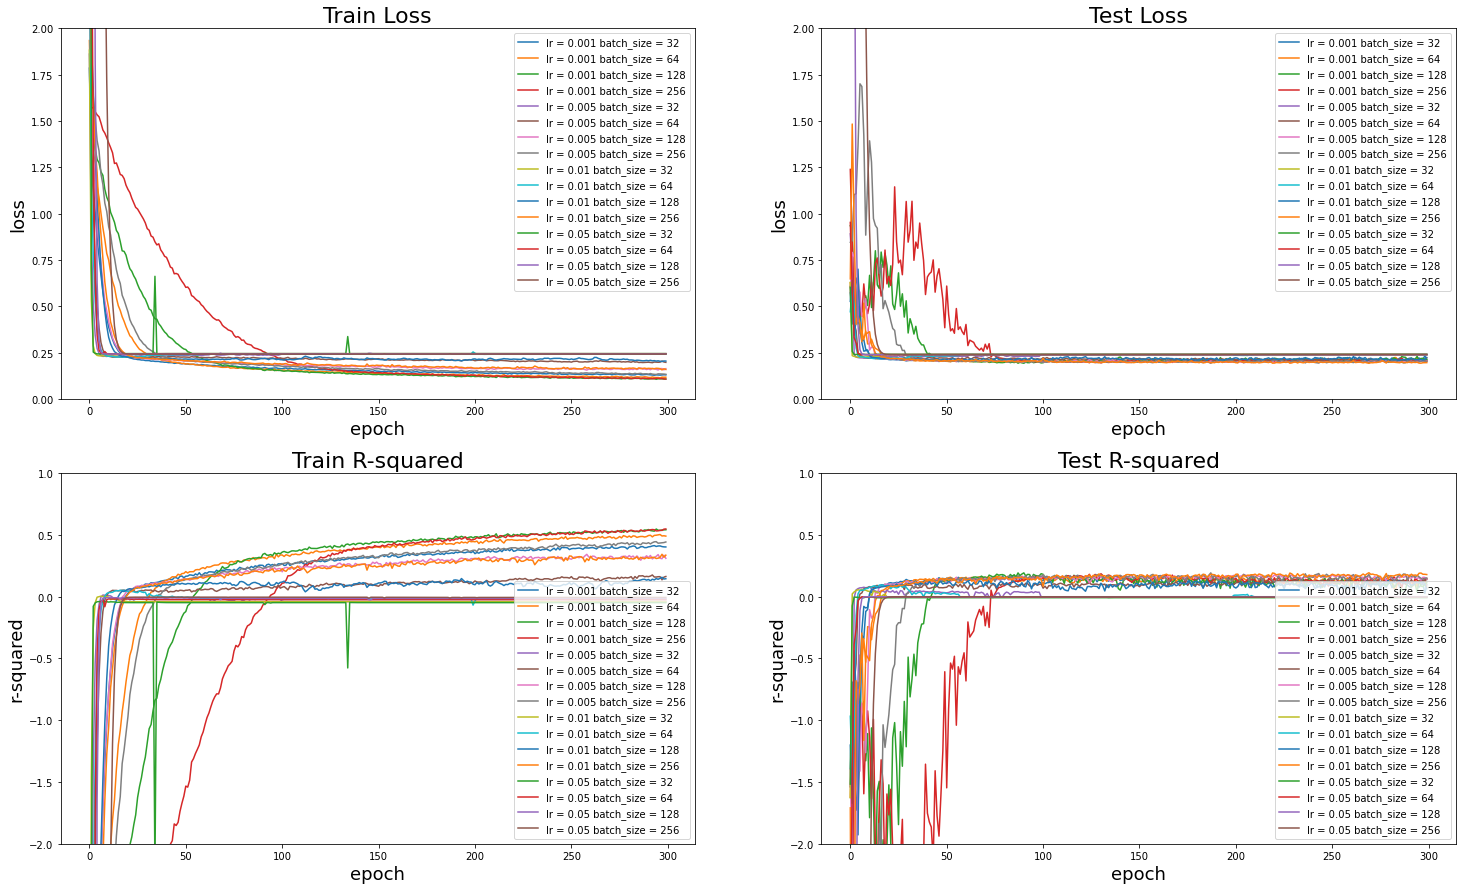

<Figure size 1800x1080 with 0 Axes>

In [15]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 2])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

In [16]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.4027574719575286
0.49052434260507105
0.5418588409141484
0.5484539916976758
-0.039333705393399164
0.1638413946301118
0.31087636811766345
0.443070964058066
-0.040190979979193915
-0.018129875233641134
0.14558974267807054
0.33639116842141836
-0.04790567971233803
-0.024018877466247236
-0.013843362933242776
-0.006013185400332861
___________________

0.09841964914951751
0.07347324623133733
0.11301004227353517
0.14683083733586344
-0.0013845329702075748
0.13859169675755167
0.1447325770341198
0.15136188979571186
-0.0013178352346105981
-0.001664380801428278
0.0646915088136929
0.17930831720979246
-0.007798735583401717
-0.0026972020840441147
-0.00017903281663245174
-0.003068754679853569
___________________

0.13042599720145584
0.11782081822281355
0.1080705121866543
0.10774327355666437
0.24342487513198766
0.19801546393078326
0.163733112551
0.13349198334027026
0.2436832711784118
0.243447907105252
0.20496811179349023
0.15953215675941412
0.24522008601952036
0.24473600998357103
0.2441236924951094
0.24

### 2 best models

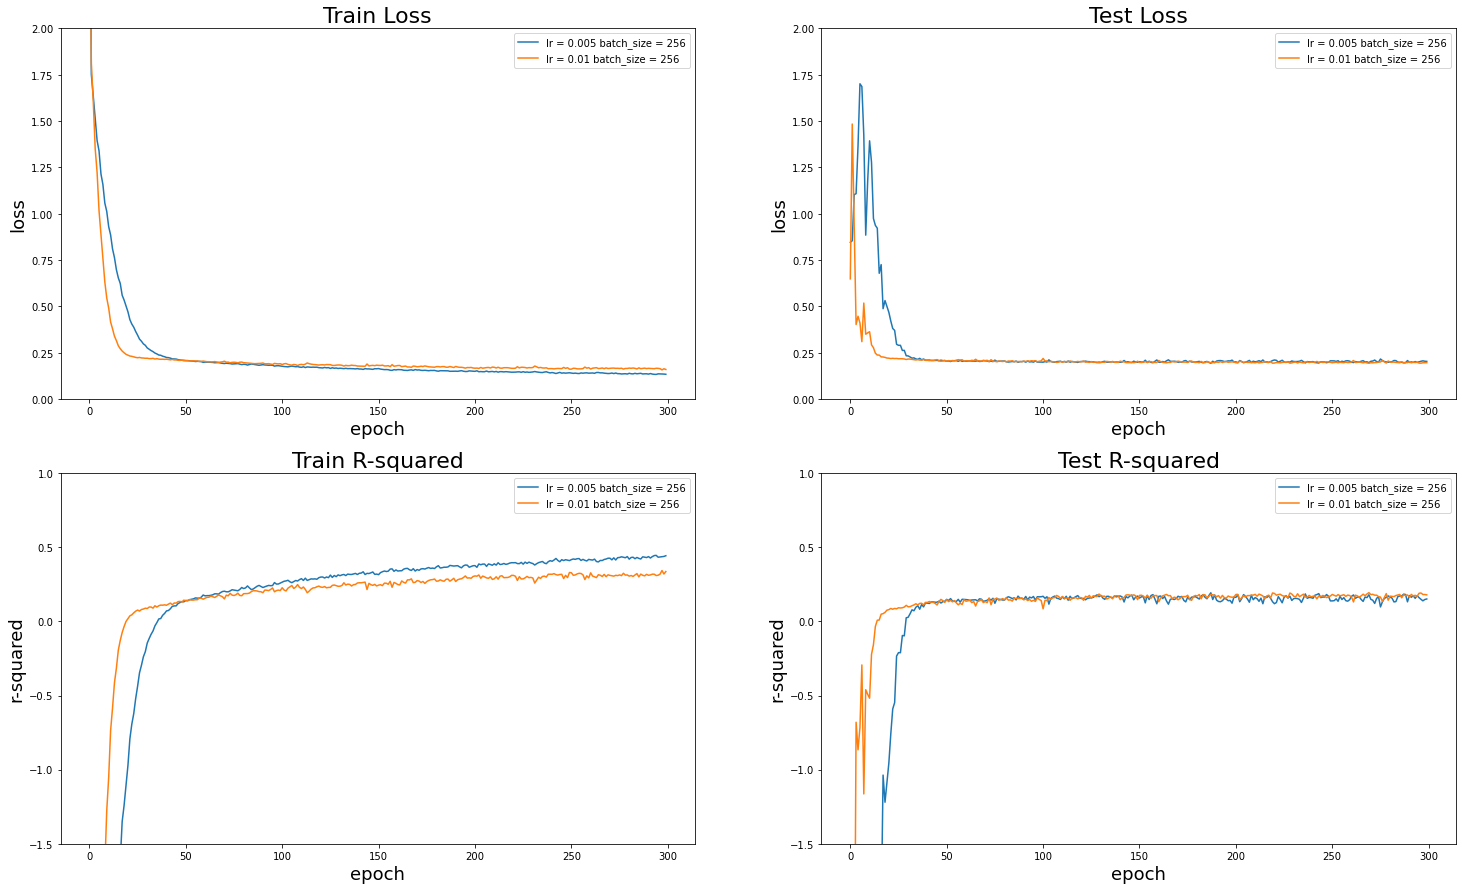

<Figure size 432x288 with 0 Axes>

In [19]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[7],label="lr = 0.005 batch_size = 256")
ax1.plot(train_losses_all[11],label="lr = 0.01 batch_size = 256")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[7],label="lr = 0.005 batch_size = 256")
ax2.plot(test_losses_all[11],label="lr = 0.01 batch_size = 256")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 2])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[7],label="lr = 0.005 batch_size = 256")
ax3.plot(train_accs_all[11],label="lr = 0.01 batch_size = 256")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[7],label="lr = 0.005 batch_size = 256")
ax4.plot(test_accs_all[11],label="lr = 0.01 batch_size = 256")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1.5,1])
plt.show()

## 4.2. Training

In [22]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=4984, shuffle=False)

In [23]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.005)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/geno_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 5.854761417095478, Accuracy: -22.383242728401203
Test Avg. loss: 0.6792177557945251, Accuracy: -1.9392226522127167
################## EPOCH 2 ##################
Train Avg. loss: 1.5464106049293127, Accuracy: -5.5210891400159525
Test Avg. loss: 0.6232506632804871, Accuracy: -1.697032624554466
################## EPOCH 3 ##################
Train Avg. loss: 1.473322665080046, Accuracy: -5.204962225517538
Test Avg. loss: 0.6056939959526062, Accuracy: -1.6210585746120825
################## EPOCH 4 ##################
Train Avg. loss: 1.4013020808880146, Accuracy: -4.911597220426838
Test Avg. loss: 1.4208277463912964, Accuracy: -5.148438910117984
################## EPOCH 5 ##################
Train Avg. loss: 1.3178165295185187, Accuracy: -4.548132804677155
Test Avg. loss: 0.7647923827171326, Accuracy: -2.309535160566744
################## EPOCH 6 ##################
Train Avg. loss: 1.2620919820589898, Accuracy: -4.324865081970316
T

Train Avg. loss: 0.2151810679680262, Accuracy: 0.10790309489880914
Test Avg. loss: 0.20420163869857788, Accuracy: 0.11634513773172261
################## EPOCH 48 ##################
Train Avg. loss: 0.21283149929382864, Accuracy: 0.11732329577078596
Test Avg. loss: 0.20221062004566193, Accuracy: 0.12496093133159869
################## EPOCH 49 ##################
Train Avg. loss: 0.21232553858023423, Accuracy: 0.11950160427682206
Test Avg. loss: 0.2015828639268875, Accuracy: 0.12767745778992823
################## EPOCH 50 ##################
Train Avg. loss: 0.20951252086804464, Accuracy: 0.13167909500886227
Test Avg. loss: 0.20112721621990204, Accuracy: 0.12964930238660188
################## EPOCH 51 ##################
Train Avg. loss: 0.20898945190203497, Accuracy: 0.1341550539070226
Test Avg. loss: 0.2010880559682846, Accuracy: 0.1298187553823794
################## EPOCH 52 ##################
Train Avg. loss: 0.20766849586596856, Accuracy: 0.14051980484598306
Test Avg. loss: 0.202953770

Train Avg. loss: 0.18157428589004737, Accuracy: 0.2460756611969515
Test Avg. loss: 0.19645199179649353, Accuracy: 0.14988071877171893
################## EPOCH 94 ##################
Train Avg. loss: 0.17931682559160086, Accuracy: 0.2536380280509328
Test Avg. loss: 0.21168026328086853, Accuracy: 0.08398242303818304
################## EPOCH 95 ##################
Train Avg. loss: 0.18154331946220154, Accuracy: 0.24561801091177954
Test Avg. loss: 0.19569382071495056, Accuracy: 0.1531615518115944
################## EPOCH 96 ##################
Train Avg. loss: 0.17897386237596855, Accuracy: 0.25681018373231995
Test Avg. loss: 0.19600613415241241, Accuracy: 0.15181000684956747
################## EPOCH 97 ##################
Train Avg. loss: 0.17805421505218896, Accuracy: 0.25911105071462276
Test Avg. loss: 0.20560579001903534, Accuracy: 0.1102688882734395
################## EPOCH 98 ##################
Train Avg. loss: 0.17770478950861174, Accuracy: 0.26026918329183235
Test Avg. loss: 0.19686529

Train Avg. loss: 0.16528907389594957, Accuracy: 0.31256382021795615
Test Avg. loss: 0.19771641492843628, Accuracy: 0.14440900666535972
################## EPOCH 140 ##################
Train Avg. loss: 0.16551498782176238, Accuracy: 0.31150210246819426
Test Avg. loss: 0.1999853402376175, Accuracy: 0.13459060595120287
################## EPOCH 141 ##################
Train Avg. loss: 0.1649810587748503, Accuracy: 0.3131652170657021
Test Avg. loss: 0.19773440062999725, Accuracy: 0.1443312600674146
################## EPOCH 142 ##################
Train Avg. loss: 0.16555615820181677, Accuracy: 0.3109261447390382
Test Avg. loss: 0.19973529875278473, Accuracy: 0.13567258296175777
################## EPOCH 143 ##################
Train Avg. loss: 0.16215008583206397, Accuracy: 0.32553511927493445
Test Avg. loss: 0.19990524649620056, Accuracy: 0.13493712842838168
################## EPOCH 144 ##################
Train Avg. loss: 0.1624471674171778, Accuracy: 0.3232477785127902
Test Avg. loss: 0.199076

Train Avg. loss: 0.15363030336224115, Accuracy: 0.36002833004700197
Test Avg. loss: 0.20134325325489044, Accuracy: 0.12871437353347093
################## EPOCH 186 ##################
Train Avg. loss: 0.152418423921634, Accuracy: 0.3657349276017297
Test Avg. loss: 0.2100709080696106, Accuracy: 0.09094660384244102
################## EPOCH 187 ##################
Train Avg. loss: 0.15525401345430276, Accuracy: 0.35386551435883934
Test Avg. loss: 0.2000523805618286, Accuracy: 0.13430046288736075
################## EPOCH 188 ##################
Train Avg. loss: 0.15289743120471636, Accuracy: 0.36293748495755945
Test Avg. loss: 0.2127840518951416, Accuracy: 0.07920585509530687
################## EPOCH 189 ##################
Train Avg. loss: 0.15283892523401824, Accuracy: 0.3640878579387598
Test Avg. loss: 0.1990252137184143, Accuracy: 0.13874544907350794
################## EPOCH 190 ##################
Train Avg. loss: 0.15079674201133925, Accuracy: 0.3721256657180399
Test Avg. loss: 0.19541579

Train Avg. loss: 0.14529972456586668, Accuracy: 0.3941090401122686
Test Avg. loss: 0.20814472436904907, Accuracy: 0.09928193896493664
################## EPOCH 232 ##################
Train Avg. loss: 0.14478310436392441, Accuracy: 0.39432686112318044
Test Avg. loss: 0.20842203497886658, Accuracy: 0.09808191056448312
################## EPOCH 233 ##################
Train Avg. loss: 0.14409721871981254, Accuracy: 0.39857240585458603
Test Avg. loss: 0.21112124621868134, Accuracy: 0.08640148053542973
################## EPOCH 234 ##################
Train Avg. loss: 0.14288378678835356, Accuracy: 0.4032325570939182
Test Avg. loss: 0.21241159737110138, Accuracy: 0.08081760544093852
################## EPOCH 235 ##################
Train Avg. loss: 0.1473957645969513, Accuracy: 0.38520653445947894
Test Avg. loss: 0.20985963940620422, Accuracy: 0.09186089739533176
################## EPOCH 236 ##################
Train Avg. loss: 0.14213130279229239, Accuracy: 0.4068232204080653
Test Avg. loss: 0.211

Train Avg. loss: 0.14065433866702592, Accuracy: 0.41361939280850435
Test Avg. loss: 0.21081607043743134, Accuracy: 0.0877221066213586
################## EPOCH 278 ##################
Train Avg. loss: 0.14280927630189139, Accuracy: 0.403906441801979
Test Avg. loss: 0.20893387496471405, Accuracy: 0.09586707691036644
################## EPOCH 279 ##################
Train Avg. loss: 0.1400682396040513, Accuracy: 0.41554572348462754
Test Avg. loss: 0.2033648043870926, Accuracy: 0.11996636128724458
################## EPOCH 280 ##################
Train Avg. loss: 0.13881474943497243, Accuracy: 0.4210624231043177
Test Avg. loss: 0.2023860663175583, Accuracy: 0.12420178373663515
################## EPOCH 281 ##################
Train Avg. loss: 0.13859979072824502, Accuracy: 0.421950527056794
Test Avg. loss: 0.21139658987522125, Accuracy: 0.0852098565531686
################## EPOCH 282 ##################
Train Avg. loss: 0.13764548387665015, Accuracy: 0.42535436183757597
Test Avg. loss: 0.202336564

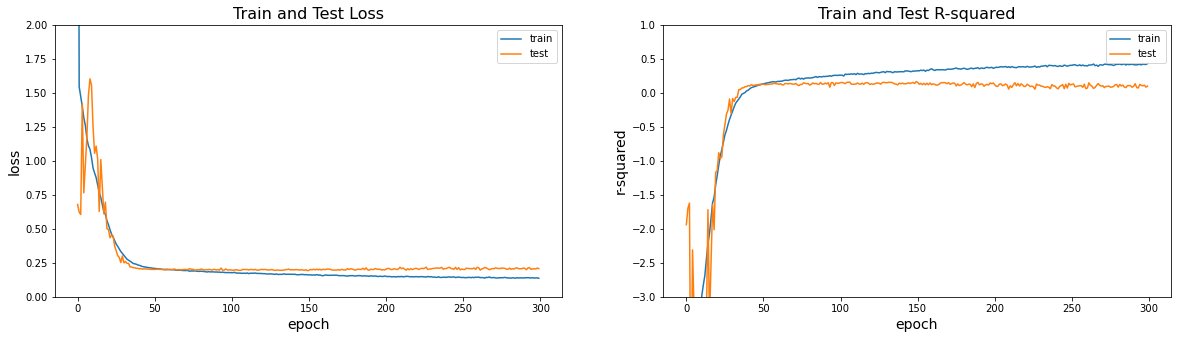

<Figure size 1440x360 with 0 Axes>

In [25]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0,2])
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.set_ylim([-3,1])
ax2.legend()
plt.show()

In [26]:
model = FCNN()
model.load_state_dict(torch.load('../../models/geno_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.3173942
MSE: 0.19244665
RMSE: 0.4386874
R2 Square 0.16721321855298155 

